# Proyecto de NLP aplicado a libros

El desarrollo del siguiente trabajo consistirá en la clasificación de libros en sus respectivos géneros. Bajo este objetivo obtendremos los datos mediante recopilación automática, aplicaremos técnicas de limpieza y normalización de texto además de probar distintas metodologías de clasificación.

### Grupo 1:
- Albacete Caballero, Luis
- Company Barber, Rebeca
- Medina Muñiz, Marta
- Venegas, Alejandra

# Índice

### 1. Webscraping: Openlibrary API

### 2. Tratamiento de los datos

- 2.1 Preprocesado
- 2.2 Extracción de características
- 2.3 Análisis EDA

### 3. Modelo propio de clasificación de género

- 3.1 Bag of Words
- 3.2 TF-IDF
- 3.4 Embeddings

### 4. Modelos pre-entrenado de análisis de género

- 4.1 Fine-tuning basado en características
- 4.2 Fine-tuning parcial (I)
- 4.3 Fine-tuning total (II)

# 1. Webscraping: Openlibrary API

En el siguiente apartado obtendremos los datos de la página web de reseñas de libros "OpenLibrary". Esta provee de una API que nos permitirá descargar conjuntos de descripciones de libros en formato .json para agilizar el proceso.

A continuación desarrollaremos dos métodos:
- extraer_subjects_ficcion: extrae los géneros de la categoría ficción.
- obtener_libros_por_subject: de cada subgénero obtendrá los libros y extraerá la información relevante devolviendo un diccionario.

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

# Paso 1: Extraer los subjects de la sección Fiction
def extraer_subjects_ficcion():
    url = "https://openlibrary.org/subjects"
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "html.parser")

    subjects_ficcion = []

    tematicas = soup.find("div", id="subjectsPage")
    all_h3s = tematicas.find_all("h3")

    for h3 in all_h3s:
        if "Fiction" in h3.text:
            # Tomamos la siguiente lista (<ul>) después del <h3>
            ul = h3.find_next_sibling("ul")
            if ul:
                for li in ul.find_all("li"):
                    a = li.find("a")
                    if a:
                        nombre = a.text.strip()
                        subject_url = a['href']
                        subject_id = subject_url.split("/")[-1]
                        subjects_ficcion.append({
                            "nombre": nombre,
                            "subject": subject_id,
                            "url": f"https://openlibrary.org{subject_url}"
                        })
            break  # Salimos una vez que encontramos "Fiction"

    return subjects_ficcion

# 2: Obtener los libros a partir de un subject
def obtener_libros_por_subject(subject_id, dict_libros, limit=2):
    url = f"https://openlibrary.org/subjects/{subject_id}.json?limit={limit}"
    response = requests.get(url)

    # Si la respuesta es correcta
    if response.status_code == 200:
        data = response.json()

        # Recorremos los libros
        for work in data.get("works", []):
            title = work.get("title")
            description = None

            # Intentamos obtener la descripción de cada libro
            work_key = work.get("key")  # Ejemplo: "/works/OL12345W"
            if work_key:


                work_url = f"https://openlibrary.org{work_key}.json"
                work_resp = requests.get(work_url)
                if work_resp.status_code == 200:
                    work_data = work_resp.json()
                    desc = work_data.get("description")
                    if isinstance(desc, dict):
                        description = desc.get("value")
                    elif isinstance(desc, str):
                        description = desc

            # Guardamos el libro solo si tiene descripción
            if description:
              if title not in dict_libros:
                  dict_libros[title] = {
                      "description": description,
                      "subjects": []}

              if subject_id not in dict_libros[title]["subjects"]:
                  dict_libros[title]["subjects"].append(subject_id)

    return dict_libros

In [ ]:
dict_libros = {}

# 1
ficcion_subjects = extraer_subjects_ficcion()
print(f"Número total de géneros: {len(ficcion_subjects)}")

# 2
for i, subj in enumerate(ficcion_subjects):
    print(f"Descargando libros para el subgénero: {subj['nombre']} ({i*100/len(ficcion_subjects):.2f} %)")
    obtener_libros_por_subject(subj['subject'], dict_libros, limit=200)

print(f"\nTotal de libros obtenidos: {len(dict_libros)}")

Número total de géneros: 14
Descargando libros para el subgénero: Fantasy (0.00 %)
Descargando libros para el subgénero: Historical Fiction (7.14 %)
Descargando libros para el subgénero: Horror (14.29 %)
Descargando libros para el subgénero: Humor (21.43 %)
Descargando libros para el subgénero: Literature (28.57 %)
Descargando libros para el subgénero: Magic (35.71 %)
Descargando libros para el subgénero: Mystery and detective stories (42.86 %)
Descargando libros para el subgénero: Plays (50.00 %)
Descargando libros para el subgénero: Poetry (57.14 %)
Descargando libros para el subgénero: Romance (64.29 %)
Descargando libros para el subgénero: Science Fiction (71.43 %)
Descargando libros para el subgénero: Short Stories (78.57 %)
Descargando libros para el subgénero: Thriller (85.71 %)
Descargando libros para el subgénero: Young Adult (92.86 %)

Total de libros obtenidos: 2002


In [ ]:
import pandas as pd

# Pasamos libros a dataframe y guardamos en CSV.
df_raw = pd.DataFrame([
    {"title": title, "description": details["description"], "subjects": details["subjects"]}
    for title, details in dict_libros.items()
])

df_raw.to_csv("libros_raw.csv", index=False)

# 2. Tratamiento de los datos

En este apartado realizaremos la limpieza del dataset recogiendo pasos como la eliminación de contenido no relevante, normalización del texto, lematizado y demás.

Seguidamente aplicaremos algunas técnicas de extracción de características como BoW, TFIDF, embeddings, ...

Finalmente remataremos la sección con un análisis de los datos resultantes.


In [ ]:
import pandas as pd
import ast

df_preprocesado = pd.read_csv("libros_raw.csv")
df_preprocesado['subjects'] = df_preprocesado['subjects'].apply(ast.literal_eval)

print('Número de libros:', df_preprocesado.shape[0])
df_preprocesado.head()

Número de libros: 2002


title  \
0  Alice's Adventures in Wonderland   
1        The Wonderful Wizard of Oz   
2                   Treasure Island   
3                Gulliver's Travels   
4                        The Prince   

                                         description  \
0  Alice's Adventures in Wonderland (commonly Ali...   
1  Over a century after its initial publication, ...   
2  Traditionally considered a coming-of-age story...   
3  A parody of traveler’s tales and a satire of h...   
4  The Prince (Italian: Il Principe [il ˈprintʃip...   

                                            subjects  
0                  [fantasy, humor, science_fiction]  
1    [fantasy, science_fiction, young_adult_fiction]  
2  [fantasy, historical_fiction, literature, thri...  
3  [fantasy, historical_fiction, humor, literatur...  
4                              [fantasy, literature]

In [ ]:
# Requerimos de librería contractions en Google Colab
# para expandir contracciones
!pip install contractions

## 2.1 Preprocesado

Para el preprocesado utilizaremos la librería "spacy" con el modelo "en_core_web_lg". Para la limpieza de los datos utilizaremos dos métodos:
- clean_markdown_text: Elimina enlaces, contenido html residual, secciones dentro de la sinopsis no deseadas...
- clean_data_revised: Expande contracciones, elimina signos de puntuación, stopwords y caracteres no alfanuméricos, pasa a minúsculas y ofrece la posibilidad de lematizar.

In [ ]:
import spacy
import re
import contractions

try:
    nlp = spacy.load('en_core_web_lg')
except OSError:
    print("Downloading en_core_news_lg model...")
    spacy.cli.download('en_core_web_lg')
    nlp = spacy.load('en_core_web_lg')

# Stopwords propios, los stopwords por defecto son demasiados
stopwords_en = [
    "the", "a", "an", "and", "or", "but", "if", "in", "on", "at", "to", "from",
    "with", "without", "of", "for", "by", "about", "as", "is", "are", "was",
    "be", "been", "being", "this", "that", "these", "those", "it", "its",
    "them", "we", "you", "i", "me", "my", "your", "their", "they", "were",
    "our", "so", "not", "no", "yes", "do", "does", "did", "have", "has", "had",
    "source", "wikipedia"
]

In [ ]:
def clean_markdown_text(text):
    # Normalize line endings
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    lines = text.splitlines()
    # Remove contains: ...
    cleaned_lines = [line for line in lines if not re.search(r"^-{5,}$|^Contains:", line)]
    text = "\n".join(cleaned_lines)
    # Remove inline markdown links: [text](url)
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', '', text)
    # Remove reference link definitions like: [1]: http://example.com
    text = re.sub(r'\[\d+\]: http[s]?://\S+', '', text, flags=re.MULTILINE)
    # Remove reference-style links: [text][1]
    text = re.sub(r'\[([^\]]+)\]\[\d+\]', '', text)
    # Remove standalone URLs (http, https)
    text = re.sub(r'^(https?)://[^\s/$.?#].[^\s]*$', '', text, flags=re.MULTILINE)
    # Remove extra blank lines
    text = re.sub(r'\n\s*\n+', '\n', text)
    # Regex to remove all HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Eliminar elementos no alfanuméricos
    text = re.sub(r'\-', ' ', text)

    return text.strip()

def clean_data_revised(doc_text, lemmatize=True,
                       use_custom_stopwords=True, keep_hyphens=False):
    # 0.a Eliminamos enlaces
    texto = clean_markdown_text(doc_text)

    # 0.b Expandimos contracciones
    texto = contractions.fix(texto)

    # Procesamos el texto sin contracciones
    doc = nlp(texto)

    cleaned_tokens = []
    for token in doc:
        # 1.a. Marcamos stopwords
        if use_custom_stopwords:
            is_stop = token.lemma_.lower() in stopwords_en
        else:
            is_stop = token.is_stop

        # 1.b. Marcamos signos de puntuación
        if is_stop or token.is_punct or token.is_space:
            if token.text == '-' and cleaned_tokens:
                pass
            elif not (token.is_punct or token.is_space):
                 continue

        # Si es puntuación o espacio, lo saltamos
        if token.is_punct or token.is_space:
            continue

        # 2. Lematizado
        if lemmatize:
            token_form = token.lemma_
        else:
            token_form = token.text

        # 3. Pasamos a minúsculas
        token_form = token_form.lower()

        # 4. Eliminar elementos no alfanuméricos
        if not keep_hyphens:
            token_form = re.sub(r'[^a-z0-9]', '', token_form)
        else:
            token_form = re.sub(r'[^a-z0-9\-]', '', token_form)

        # Conservar token limpio
        if token_form and len(token_form) > 1:
            cleaned_tokens.append(token_form)

    return " ".join(cleaned_tokens)

In [ ]:
# Aplicar preprocesado (y lematizado)
df_preprocesado['preprocesado_lema'] = \
  df_preprocesado['description'].apply(clean_data_revised, lemmatize=True)
df_preprocesado['preprocesado'] = \
  df_preprocesado['description'].apply(clean_data_revised, lemmatize=False)

df_preprocesado['texto_limpio'] = \
  df_preprocesado['description'].apply(clean_markdown_text)

**Un ejemplo de preprocesado**

In [ ]:
print("Sinopsis original: ")
print(df_preprocesado.iloc[16]['description'])
print("-" * 50)
print("Sinopsis procesada (no lema): ")
print(df_preprocesado.iloc[16]['preprocesado'])
print("-" * 50)
print("Sinopsis procesada (lema): ")
print(df_preprocesado.iloc[16]['preprocesado_lema'])
print("-" * 50)
print("Sinopsis procesada (limpia): ")
print(df_preprocesado.iloc[16]['texto_limpio'])

Sinopsis original: 
A very real little girl named Alice follows a remarkable rabbit down a rabbit hole and steps through a looking-glass to come face to face with some of the strangest adventures and some of the oddest characters in all literature. The crusty Duchess, the Mad Hatter, the weeping Mock Turtle, the diabolical Queen of Hearts, the Cheshire-Cat, Tweedledum and Tweedledee--each one is more eccentric, and more entertaining, than the last. And all of them could only have come from the pen of Lewis Carroll, one of the few adults ever to enter successfully the children's world of make-believe--a wonderland where the impossible becomes possible, the unreal, real...where the heights of adventure are limited only by the depths of imagination.
--back cover

Contains:

 - [Alice's Adventures in Wonderland](https://openlibrary.org/works/OL8193508W)
 - [Through the Looking Glass, and What Alice Found There][2]

  [2]: https://openlibrary.org/works/OL15298516W
--------------------------

**Distribución de Palabras**, en esta subsección analizaremos el número de palabras y retiraremos aquellos libros cuyas descripciones sea reducida.

Creamos una variable que contiene la cantidad de palabras del texto preprocesado.

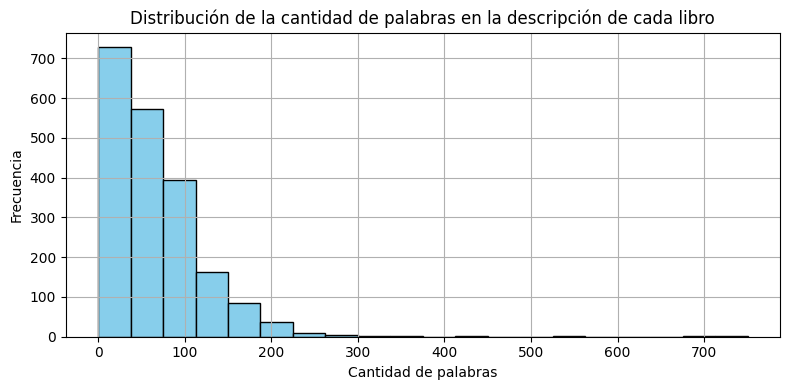

In [ ]:
import matplotlib.pyplot as plt

df_preprocesado['contador_palabras'] = df_preprocesado['preprocesado'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 4))
plt.hist(df_preprocesado['contador_palabras'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la cantidad de palabras en la descripción de cada libro')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Percentiles
df_preprocesado['contador_palabras'].quantile([i/10 for i in [0.5,1,9,9.5]])

0.05      9.00
0.10     13.10
0.90    133.00
0.95    163.95
Name: contador_palabras, dtype: float64

Eliminamos los registros con menos de 14 palabras, que corresponden al percentil del 10% inferior y trabajamos con el dataset filtrado.

In [ ]:
df_preprocesado = df_preprocesado[df_preprocesado['contador_palabras'] > 13].copy()

# Mostrar cuántas filas quedaron
print(f"Filas con más de 13 palabras: {df_preprocesado.shape[0]}")

Filas con más de 13 palabras: 1801


**Distribución Géneros**

Tras el proceso de limpieza de datos, se trabaja con un total de 1801 libros, los cuales están clasificados en 14 géneros literarios distintos.

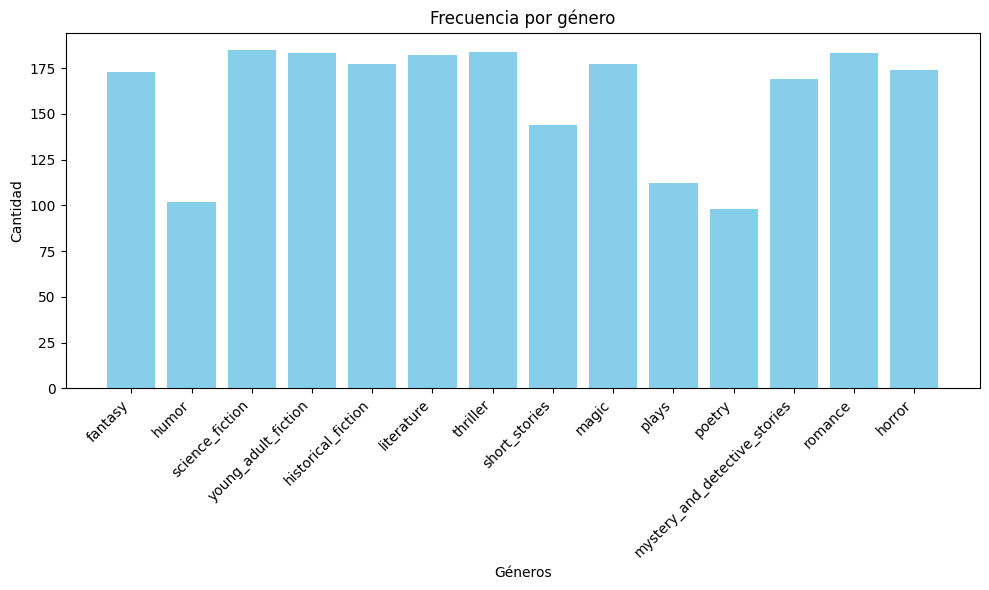

In [ ]:
from collections import Counter

# Aplanar todas las listas de la columna 'subjects' en una sola lista
all_subjects = sum(df_preprocesado['subjects'], [])

# Contar las ocurrencias
counter = Counter(all_subjects)

# Convertir a DataFrame si lo quieres en ese formato
subject_counts = pd.DataFrame(counter.items(), columns=['subject', 'count'])

plt.figure(figsize=(10, 6))
plt.bar(subject_counts['subject'], subject_counts['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Géneros')
plt.ylabel('Cantidad')
plt.title('Frecuencia por género')
plt.tight_layout()
plt.show()


Total de libros: 1801


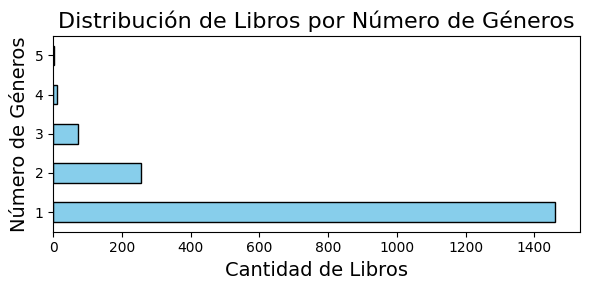

In [ ]:
import matplotlib.pyplot as plt

# Obtener el número de géneros por libro
generos_en_df_libros = df_preprocesado['subjects'].apply(len)

# Contar cuántos libros tienen cada cantidad de géneros
multi_genre_counts = generos_en_df_libros.value_counts().sort_index()
# Crear un gráfico horizontal
plt.figure(figsize=(6, 3))
multi_genre_counts.plot(kind='barh', color='skyblue', edgecolor='black')

# Agregar títulos y etiquetas
plt.title('Distribución de Libros por Número de Géneros', fontsize=16)
plt.xlabel('Cantidad de Libros', fontsize=14)
plt.ylabel('Número de Géneros', fontsize=14)

# Mostrar el número total de libros
print(f"\nTotal de libros: {len(df_preprocesado)}")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Como veremos más adelante los 14 géneros propuestos no son un buen objetivo de clasificación. Imposibilitando una debida clasificación. Es por ello que en el siguiente bloque de código cambiaremos la etiqueta para que tenga un resultado más preciso respecto a la realidad. Agrupando géneros similares como lo son la "Magia" y la "Fantasía" y eliminando otros los cuáles no tiene sentido comparar como "Historias Cortas".

In [ ]:
df_preprocesado['subjects_old'] = df_preprocesado['subjects'].copy()

df_preprocesado['subjects'] = df_preprocesado['subjects'].apply(lambda x: [item for item in x if item != 'humor'])
df_preprocesado['subjects'] = df_preprocesado['subjects'].apply(lambda x: [item for item in x if item != 'romance'])
df_preprocesado['subjects'] = df_preprocesado['subjects'].apply(lambda x: [item for item in x if item != 'historical_fiction'])
df_preprocesado['subjects'] = df_preprocesado['subjects'].apply(lambda x: [item for item in x if item != 'young_adult_fiction'])
df_preprocesado['subjects'] = df_preprocesado['subjects'].apply(lambda x: [item for item in x if item != 'short_stories'])

# Función para unificar los géneros
def unificar_generos(subjects):
    nuevos_subjects = []
    for s in subjects:
        if s in ['magic', 'fantasy']:
            nuevo = 'fantasy'
        elif s in ['poetry', 'literature', 'plays']:
            nuevo = 'literature'
        elif s in ['thriller', 'horror', 'mystery_and_detective_stories']:
            nuevo = 'mystery'
        else:
            nuevo = s
        if nuevo not in nuevos_subjects:
            nuevos_subjects.append(nuevo)
    return nuevos_subjects

# Aplicar la función a la columna 'subjects'
df_preprocesado['subjects'] = df_preprocesado['subjects'].apply(unificar_generos)

df_preprocesado = df_preprocesado[df_preprocesado['subjects'].map(len) > 0]

print('Número de libros:', df_preprocesado.shape[0])
df_preprocesado.head()

Número de libros: 1240


title  \
0  Alice's Adventures in Wonderland   
1        The Wonderful Wizard of Oz   
2                   Treasure Island   
3                Gulliver's Travels   
4                        The Prince   

                                         description  \
0  Alice's Adventures in Wonderland (commonly Ali...   
1  Over a century after its initial publication, ...   
2  Traditionally considered a coming-of-age story...   
3  A parody of traveler’s tales and a satire of h...   
4  The Prince (Italian: Il Principe [il ˈprintʃip...   

                         subjects  \
0      [fantasy, science_fiction]   
1      [fantasy, science_fiction]   
2  [fantasy, literature, mystery]   
3           [fantasy, literature]   
4           [fantasy, literature]   

                                   preprocesado_lema  \
0  alice adventures wonderland commonly alice won...   
1  over century after initial publication wonderf...   
2  traditionally consider coming age story treasu...   
3  parody traveler tale satire human nature gulli...   
4  prince italian il principe il printipe latin d...   

                                        preprocesado  \
0  alice adventures wonderland commonly alice won...   
1  over century after initial publication wonderf...   
2  traditionally considered coming age story trea...   
3  parody traveler tales satire human nature gull...   
4  prince italian il principe il printipe latin d...   

                                        texto_limpio  contador_palabras  \
0  Alice's Adventures in Wonderland (commonly Ali...                 48   
1  Over a century after its initial publication, ...                 44   
2  Traditionally considered a coming of age story...                 55   
3  A parody of traveler’s tales and a satire of h...                149   
4  The Prince (Italian: Il Principe [il ˈprintʃip...                117   

                                        subjects_old  
0                  [fantasy, humor, science_fiction]  
1    [fantasy, science_fiction, young_adult_fiction]  
2  [fantasy, historical_fiction, literature, thri...  
3  [fantasy, historical_fiction, humor, literatur...  
4                              [fantasy, literature]

In [ ]:
# Guardamos los datos finalmente limpios y preparados para la
# extracción de características
df_preprocesado.to_csv("libros_filtrado.csv", index=False)

## 2.2 Extracción de características (BoW, Tf-idf, Embeddings)

En esta subsección obtenemos el BoW, TF-IDF, embeddings y preparamos la etiqueta a predecir.

In [ ]:
import ast
import pandas as pd
df_libros = pd.read_csv("libros_filtrado.csv")
df_libros['subjects'] = df_libros['subjects'].apply(ast.literal_eval)
df_libros['subjects_old'] = df_libros['subjects_old'].apply(ast.literal_eval)

## Usando Bow
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1, 3), max_features=10000)
bow_lema = vect.fit_transform(df_libros['preprocesado_lema'])
bow_no_lema = vect.fit_transform(df_libros['preprocesado'])

## Usando TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
tfidf_lema = vect.fit_transform(df_libros['preprocesado_lema'])
tfidf_no_lema = vect.fit_transform(df_libros['preprocesado'])

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# 2. Función para obtener embedding de una sinopsis
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state  # [1, seq_len, 768]
    cls_embedding = last_hidden_state[:, 0, :]
    return cls_embedding.numpy()

# 3. Aplicar a cada fila del DataFrame
embeddings_limpio = []

for sinopsis in tqdm(df_libros['texto_limpio']):
    emb = get_bert_embedding(sinopsis)
    embeddings_limpio.append(emb)

# 4. Convertir a matriz de NumPy
import numpy as np
embeddings_limpio = np.stack(embeddings_limpio).reshape(1240, 768)  # Shape: (n_samples, 768)

# Guardar embeddings lematizados y no lematizados
np.save('embeddings_limpio.npy', embeddings_limpio)

print("\nMatriz de embeddings:", embeddings_limpio.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1240/1240 [07:24<00:00,  2.79it/s]



Matriz de embeddings: (1240, 768)


In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Cargar modelo
model = SentenceTransformer('all-MiniLM-L6-v2')
textos = df_libros['texto_limpio'].dropna().astype(str).tolist()

# Obtener embeddings (esto usa batching interno)
embeddings_sentences_transformers = model.encode(
    textos, show_progress_bar=True, convert_to_numpy=True)

# Guardar embeddings
np.save('embeddings_sentences_transformers.npy', embeddings_sentences_transformers)

print("\nMatriz de embeddings:", embeddings_sentences_transformers.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/39 [00:00<?, ?it/s]


Matriz de embeddings: (1240, 384)


In [ ]:
# para entrenar un clasificador multi-etiqueta generamos una matriz
# binaria de las etiquetas.
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_raw = mlb.fit_transform(df_libros['subjects'])

# Guardamos las clases utilizadas
clases = mlb.classes_
num_classes = clases.shape
print("Número de clases (adaptado): ", num_classes[0], "\nClases (adaptado): \n", clases)

mlb1 = MultiLabelBinarizer()
y_raw_old = mlb1.fit_transform(df_libros['subjects_old'])
clases1 = mlb1.classes_
num_classes1 = clases1.shape
print("\nNúmero de clases (original): ", num_classes1[0], "\nClases (adaptado): \n", clases1)

Número de clases (adaptado):  4 
Clases (adaptado): 
 ['fantasy' 'literature' 'mystery' 'science_fiction']

Número de clases (original):  14 
Clases (adaptado): 
 ['fantasy' 'historical_fiction' 'horror' 'humor' 'literature' 'magic'
 'mystery_and_detective_stories' 'plays' 'poetry' 'romance'
 'science_fiction' 'short_stories' 'thriller' 'young_adult_fiction']


## 2.3 Análisis EDA

Para el análisis analizaremos los siguientes elementos:
- Distribución de las palabras.
- Distribuciones de los géneros.

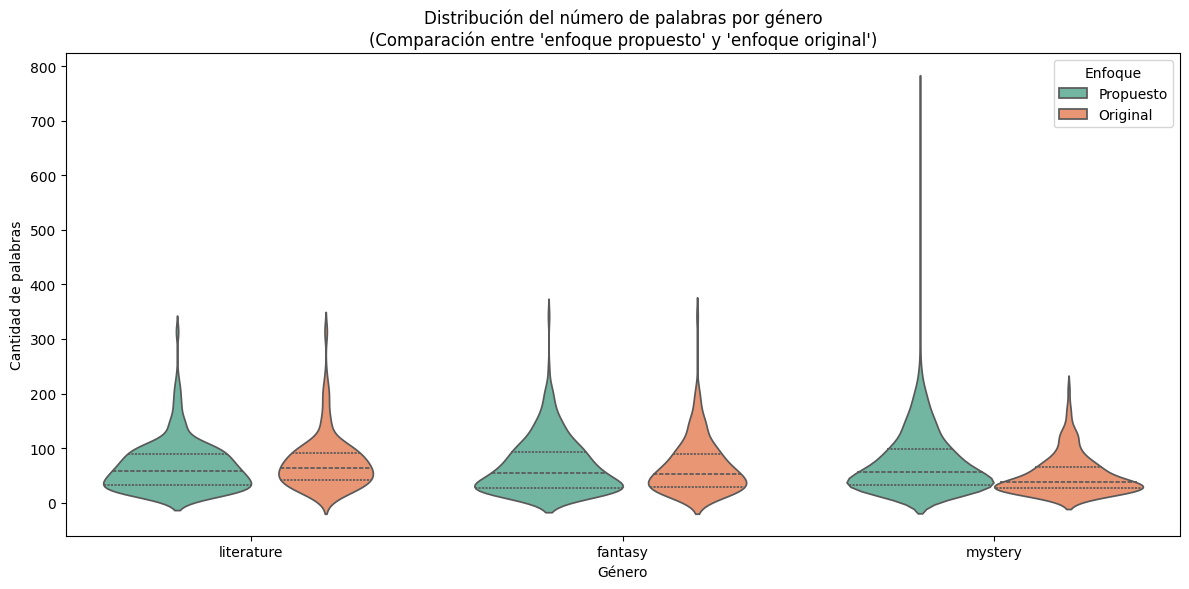

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def comparar_generos_personalizados(df, generos_nuevos, generos_antiguos):
    """
    Compara la distribución del número de palabras en la columna 'preprocesado'
    para cada género, considerando que la etiqueta puede diferir en 'subjects' y 'subjects_old'.

    Parámetros:
      - df: DataFrame con las columnas 'preprocesado', 'subjects' y 'subjects_old'.
      - generos_nuevos: lista de géneros a buscar en 'subjects'.
      - generos_antiguos: lista de géneros a buscar en 'subjects_old'.

    Se asume que generos_nuevos y generos_antiguos tienen la misma longitud.
    Para cada posición, se asocia un mismo grupo (por ejemplo, "literature") que se mostrará en el plot.
    """

    if len(generos_nuevos) != len(generos_antiguos):
        print("Las listas de géneros deben tener la misma longitud.")
        return

    datos = []

    # Para cada par de géneros (nuevo y antiguo)
    for genero_nuevo, genero_antiguo in zip(generos_nuevos, generos_antiguos):
        # Filtrar en 'subjects' con el género nuevo
        df_nuevo = df[
            df['subjects'].apply(lambda x: genero_nuevo in x if isinstance(x, list) else False)
        ].copy()
        df_nuevo["word_count"] = df_nuevo["preprocesado"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
        # Asignamos una etiqueta común al grupo (por ejemplo, usando el género del nuevo)
        df_nuevo["genero"] = genero_nuevo
        df_nuevo["origen"] = "subjects"

        # Filtrar en 'subjects_old' con el género antiguo
        df_antiguo = df[
            df['subjects_old'].apply(lambda x: genero_antiguo in x if isinstance(x, list) else False)
        ].copy()
        df_antiguo["word_count"] = df_antiguo["preprocesado"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
        # La misma etiqueta para el grupo, para después unir los datos
        df_antiguo["genero"] = genero_nuevo
        df_antiguo["origen"] = "subjects_old"

        datos.append(df_nuevo[["word_count", "genero", "origen"]])
        datos.append(df_antiguo[["word_count", "genero", "origen"]])

    # Unir todos los datos en un mismo DataFrame
    df_generos = pd.concat(datos)

    if df_generos.empty:
        print("No se encontraron libros para los géneros especificados.")
        return

    # Crear el gráfico, diferenciando por origen usando hue
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df_generos, x="genero", y="word_count", hue="origen", palette="Set2", inner="quartile")

    # Obtener handles y labels actuales
    handles, labels = plt.gca().get_legend_handles_labels()

    # Crear diccionario de traducción
    generos = {
        "subjects": "Propuesto",
        "subjects_old": "Original"
    }

    # Reemplazar etiquetas
    labels = [generos.get(label, label) for label in labels]

    # Aplicar leyenda corregida
    plt.legend(handles=handles, labels=labels, title="Enfoque")

    # Títulos y etiquetas
    plt.title("Distribución del número de palabras por género\n(Comparación entre 'enfoque propuesto' y 'enfoque original')")
    plt.xlabel("Género")
    plt.ylabel("Cantidad de palabras")
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
generos_nuevos = ["literature", "fantasy", "mystery"]
generos_antiguos = ["literature", "fantasy", "mystery_and_detective_stories"]

comparar_generos_personalizados(df_libros, generos_nuevos, generos_antiguos)


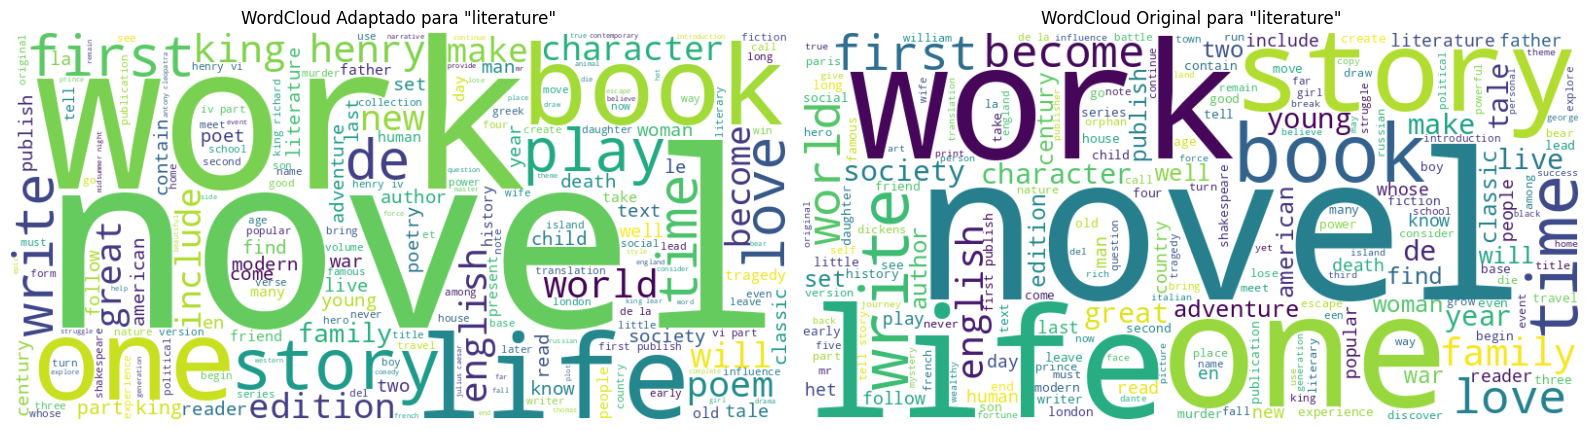

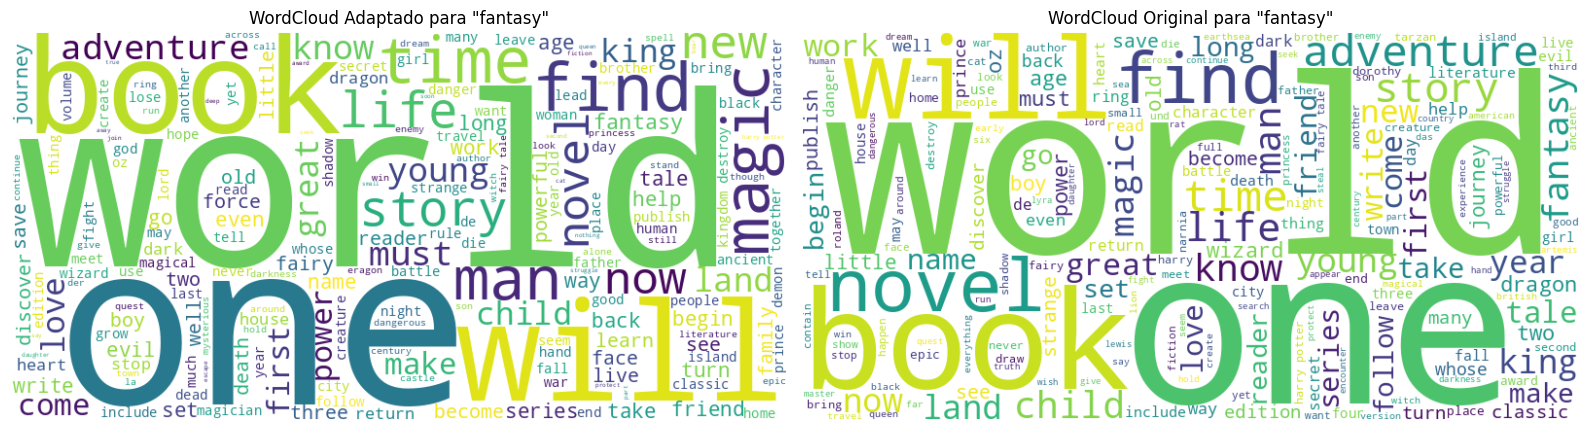

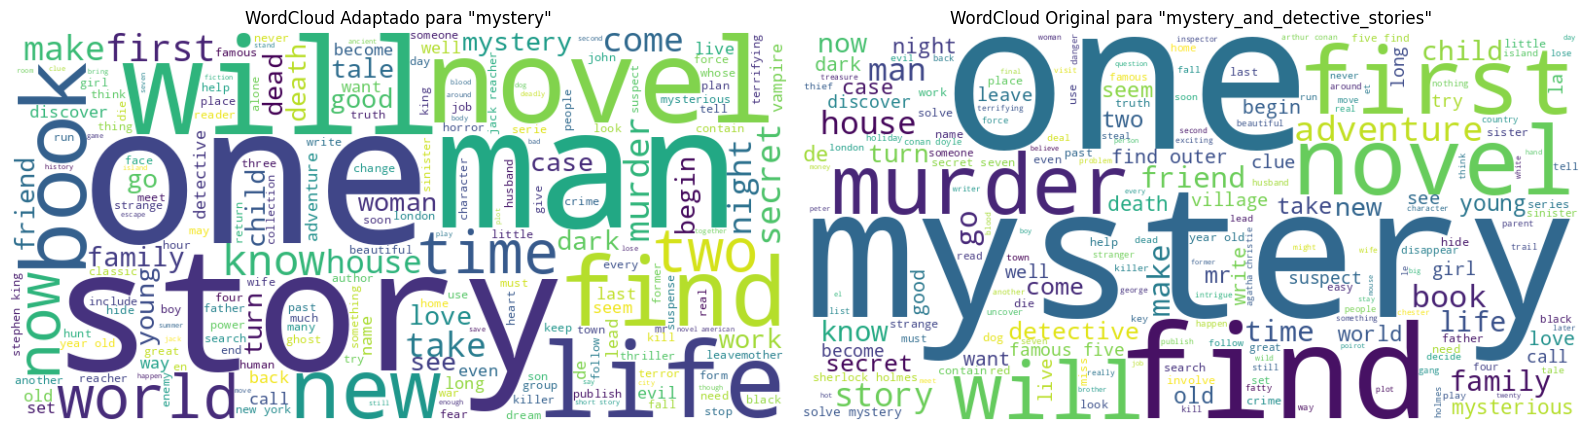

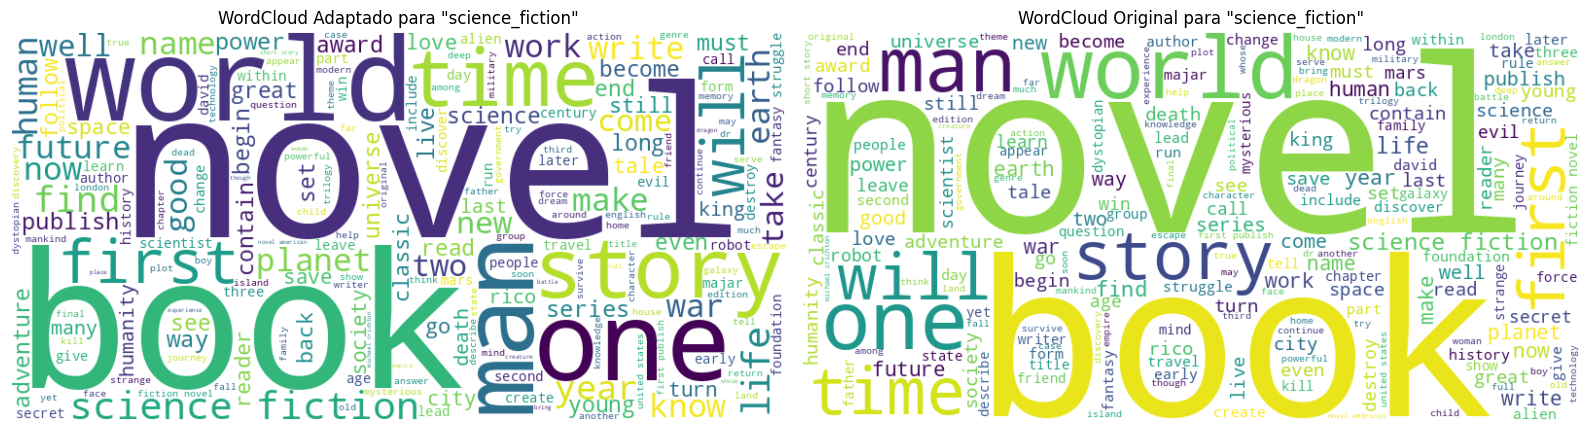

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def mostrar_wd_por_clase(df, clase1, clase2):
    # Filtrar textos por clase
    text_clase_adaptado = " ".join(
        df_libros[df_libros['subjects'].apply(lambda lista: clase1 in lista)]['preprocesado_lema'].dropna().astype(str)
    )
    text_clase_original = " ".join(
        df_libros[df_libros['subjects_old'].apply(lambda lista: clase2 in lista)]['preprocesado_lema'].dropna().astype(str)
    )

    # Crear las WordClouds
    wc1 = WordCloud(width=800, height=400, background_color='white').generate(text_clase_adaptado)
    wc2 = WordCloud(width=800, height=400, background_color='white').generate(text_clase_original)

    # Mostrar lado a lado
    plt.figure(figsize=(16, 8))

    # Wordcloud de géneros original
    plt.subplot(1, 2, 1)
    plt.imshow(wc1, interpolation='bilinear')
    plt.title(f'WordCloud Adaptado para "{clase1}"')
    plt.axis('off')

    # Wordcloud de géneros adaptado
    plt.subplot(1, 2, 2)
    plt.imshow(wc2, interpolation='bilinear')
    plt.title(f'WordCloud Original para "{clase2}"')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

mostrar_wd_por_clase(df_libros, 'literature', 'literature')
mostrar_wd_por_clase(df_libros, 'fantasy', 'fantasy')
mostrar_wd_por_clase(df_libros, 'mystery', 'mystery_and_detective_stories')
mostrar_wd_por_clase(df_libros, 'science_fiction', 'science_fiction') # Está igual

La librería Wordclouds en Python refleja la frecuencia relativa de las palabras a parte de eliminar stopwords. Es por ello interesante, ver explícitamente las frecuencias reales de las palabras.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def mostrar_top_palabras_por_clase(df, clase_adaptada, clase_original, top_n=6):
    # Obtener textos por clase
    text_adaptado = " ".join(
        df[df['subjects'].apply(lambda lista: clase_adaptada in lista)]['preprocesado_lema'].dropna().astype(str)
    ).split()

    text_original = " ".join(
        df[df['subjects_old'].apply(lambda lista: clase_original in lista)]['preprocesado_lema'].dropna().astype(str)
    ).split()

    # Contar palabras
    freq_adaptado = Counter(text_adaptado).most_common(top_n)
    freq_original = Counter(text_original).most_common(top_n)

    # Separar palabras y frecuencias
    palabras_adaptado, valores_adaptado = zip(*freq_adaptado) if freq_adaptado else ([], [])
    palabras_original, valores_original = zip(*freq_original) if freq_original else ([], [])

    # Crear gráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].bar(palabras_adaptado, valores_adaptado, color='skyblue')
    axes[0].set_title(f'Top {top_n} palabras - Adaptado: {clase_adaptada}')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_ylim(0, max(valores_adaptado + valores_original) + 5)

    axes[1].bar(palabras_original, valores_original, color='lightcoral')
    axes[1].set_title(f'Top {top_n} palabras - Original: {clase_original}')
    axes[1].set_ylim(0, max(valores_adaptado + valores_original) + 5)

    plt.tight_layout()
    plt.show()

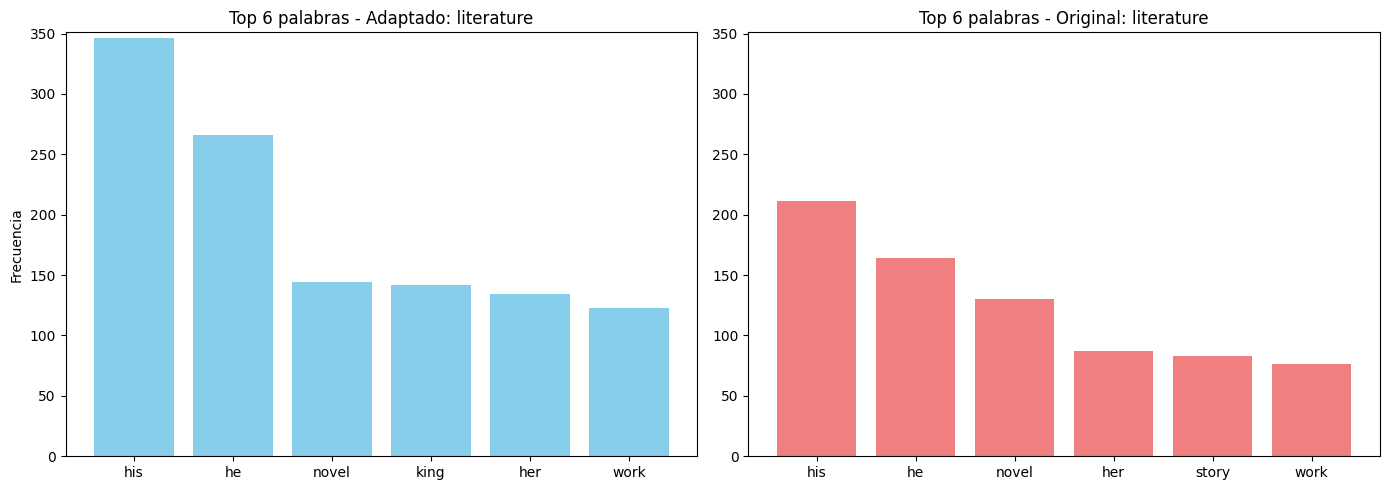

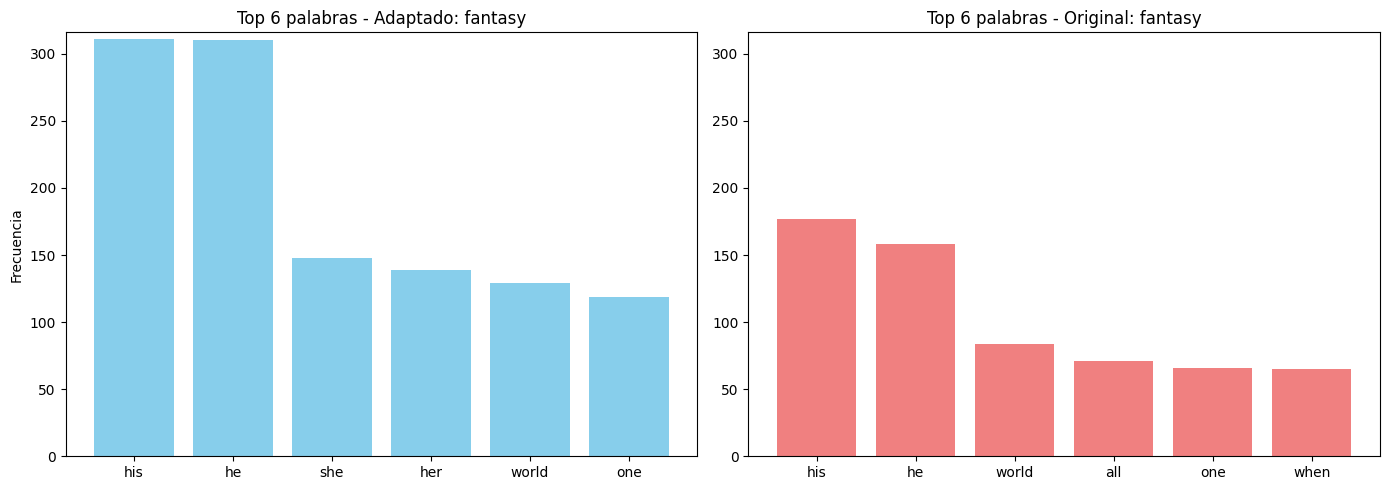

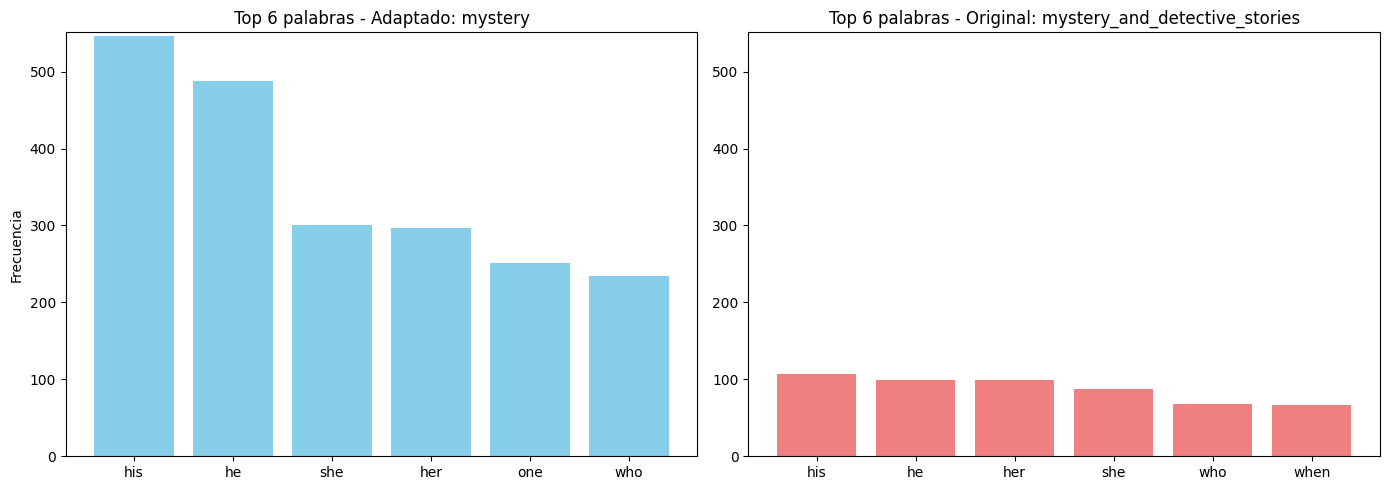

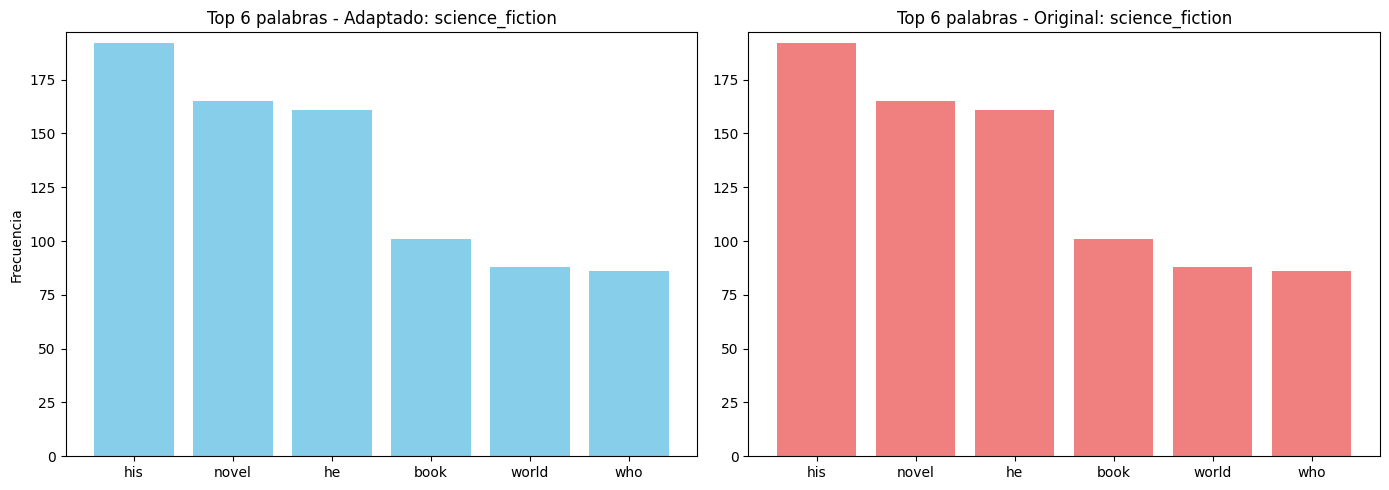

In [ ]:
mostrar_top_palabras_por_clase(df_libros, 'literature', 'literature')
mostrar_top_palabras_por_clase(df_libros, 'fantasy', 'fantasy')
mostrar_top_palabras_por_clase(df_libros, 'mystery', 'mystery_and_detective_stories')
mostrar_top_palabras_por_clase(df_libros, 'science_fiction', 'science_fiction')

In [ ]:
import umap
import pandas as pd
import numpy as np
import ast
import plotly.express as px

def visualize_single_subject_embeddings_umap_2d_interactive(
    embeddings: np.ndarray, book_df: pd.DataFrame,
    subject_column: str = 'subjects',
    title_column: str = 'title',
    random_state: int = 42):
    """
    Visualiza interactivamente los embeddings de libros con una única etiqueta usando UMAP en 2D,
    coloreado por género.

    Args:
        embeddings (np.ndarray): Array 2D con los embeddings de los libros.
        book_df (pd.DataFrame): DataFrame con la información de los libros.
        subject_column (str): Nombre de la columna que contiene la lista de géneros.
        title_column (str): Nombre de la columna que contiene el título del libro.
        random_state (int): Semilla para reproducibilidad. Default = 42.

    Returns:
        plotly.graph_objects.Figure: gráfico interactivo en 2D.
    """
    if embeddings.shape[0] != book_df.shape[0]:
        raise ValueError("El número de embeddings debe coincidir con el número de libros.")
    if subject_column not in book_df.columns:
        raise ValueError(f"La columna '{subject_column}' no existe en el DataFrame.")
    if title_column not in book_df.columns:
        raise ValueError(f"La columna '{title_column}' no existe en el DataFrame.")

    # Asegurar que la columna de etiquetas sea una lista
    if isinstance(book_df[subject_column].iloc[0], str):
        try:
            book_df[subject_column] = book_df[subject_column].apply(ast.literal_eval)
        except (SyntaxError, ValueError) as e:
            raise ValueError(f"Error al parsear la columna de etiquetas: {e}")

    # Filtrar libros con una sola etiqueta
    mask_unico = book_df[subject_column].apply(lambda x: isinstance(x, list) and len(x) == 1)
    df_unico = book_df[mask_unico].copy()
    embeddings_unico = embeddings[mask_unico]

    if df_unico.empty or embeddings_unico.shape[0] == 0:
        print("No se encontraron libros con una única etiqueta.")
        return

    # Extraer la etiqueta principal
    df_unico['single_subject'] = df_unico[subject_column].apply(lambda x: x[0])

    # UMAP a 2D
    reducer = umap.UMAP(n_components=2, random_state=random_state, n_neighbors=15, min_dist=0.1)
    emb_2d = reducer.fit_transform(embeddings_unico)
    df_unico['umap_1'] = emb_2d[:, 0]
    df_unico['umap_2'] = emb_2d[:, 1]

    # Crear gráfico interactivo
    fig = px.scatter(
        df_unico,
        x='umap_1',
        y='umap_2',
        color='single_subject',
        hover_data={title_column: True, 'umap_1': False, 'umap_2': False},
        title='Visualización Interactiva UMAP 2D - Libros con una sola etiqueta'
    )

    fig.update_layout(
        xaxis_title='Dimensión UMAP 1',
        yaxis_title='Dimensión UMAP 2',
        legend_title='Género',
        width=1000,
        height=700
    )

    return fig

In [ ]:
fig1 = visualize_single_subject_embeddings_umap_2d_interactive(
    embeddings_sentences_transformers, df_libros, subject_column="subjects_old")
fig2 = visualize_single_subject_embeddings_umap_2d_interactive(
    embeddings_sentences_transformers, df_libros)

from plotly.subplots import make_subplots

combined_fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distribución original",
                                    "Distribución adaptada"))

for trace in fig1.data:
    combined_fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.update_layout(height=500, width=1000,
                           title_text="Distribuciones géneros embeddings Sentence Transformer")
combined_fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
fig1 = visualize_single_subject_embeddings_umap_2d_interactive(
    embeddings_limpio, df_libros, subject_column="subjects_old")
fig2 = visualize_single_subject_embeddings_umap_2d_interactive(
    embeddings_limpio, df_libros)

from plotly.subplots import make_subplots

combined_fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distribución original",
                                    "Distribución adaptada"))

for trace in fig1.data:
    combined_fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    combined_fig.add_trace(trace, row=1, col=2)

combined_fig.update_layout(height=500, width=1000,
                           title_text="Distribuciones géneros embeddings BERT")
combined_fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



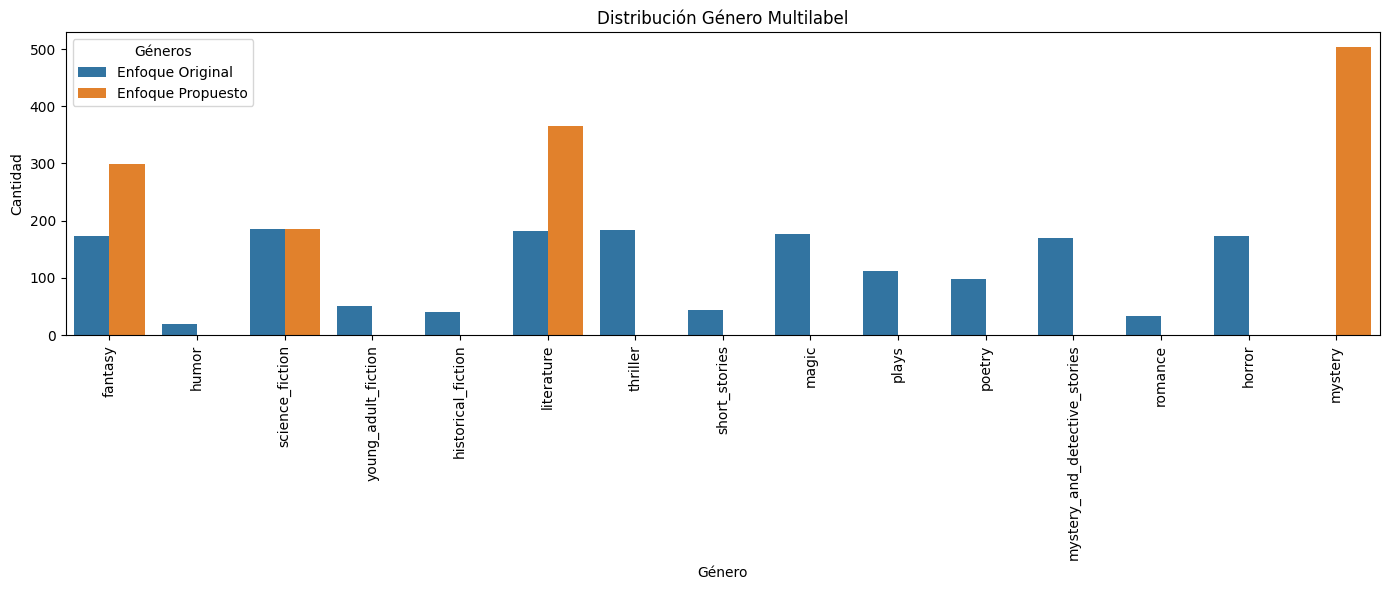

In [ ]:
import pandas as pd
from collections import Counter

# Flatten subjects_old
labels_old = sum(df_libros['subjects_old'], [])
df_old = pd.DataFrame(Counter(labels_old).items(), columns=['label', 'count'])
df_old['column'] = 'Enfoque Original'

# Flatten subjects
labels_new = sum(df_libros['subjects'], [])
df_new = pd.DataFrame(Counter(labels_new).items(), columns=['label', 'count'])
df_new['column'] = 'Enfoque Propuesto'

# Combine both for plotting
df_combined = pd.concat([df_old, df_new])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.barplot(data=df_combined, x='label', y='count', hue='column')

plt.title('Distribución Género Multilabel')
plt.xticks(rotation=90)
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.legend(title='Géneros')
plt.tight_layout()
plt.show()

# 3. Modelo propio de clasificación de género

Vamos a emplear las distintas características extraídas (BoW, tf-idf y embeddings) para entrenar modelos de machine learning, comparando también la diferencia entre emplear lematizado o no. El objetivo del trabajo es una clasificación multietiqueta, ya que un libro puede pertenecer a varios géneros, por lo que emplearemos estrategias multietiqueta (MultiOutputClassifier y OnevsRestClassifier) sobre tres clasificadores distintos: Xgboost, regresión logística y SGDCClassifier.

Durante la evaluación, si el modelo permite obtener probabilidades (predict_proba), se ajusta un umbral óptimo de decisión por cada etiqueta para mejorar el rendimiento usando la curva de precisión-recall. Esto mejora los resultados con respecto a un modelo con umbral por defecto, que tiende a ser 'conservador' y no asigna un género salvo que esté muy seguro. Luego, se calcula el F1-score ponderado, la exactitud y un informe detallado por género.

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split


def multilabel_evaluation(X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa múltiples clasificadores y estrategias para clasificación multilabel,
    ajustando umbrales por etiqueta si predict_proba está disponible.
    """
    # Clasificadores que usaremos
    classifiers = {
        "XGBoost": xgb.XGBClassifier(n_estimators=100, scale_pos_weight=5, eval_metric='aucpr'),
        "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
        "SGDClassifier": SGDClassifier(loss='log_loss', class_weight='balanced', max_iter=1000),
    }

    strategies = {
        "MultiOutput": MultiOutputClassifier,
        "OneVsRest": OneVsRestClassifier
    }

    results = {}

    for strategy_name, wrapper in strategies.items():
        for clf_name, base_clf in classifiers.items():
            key = f"{strategy_name}_{clf_name}"
            print(f"\nEntrenando y evaluando: {key}")

            model = wrapper(base_clf)
            model.fit(X_train, y_train)

            # Verificamos si soporta predict_proba
            try:
                y_proba = model.predict_proba(X_test)

                # Algunos clasificadores devuelven lista de arrays en lugar de matriz
                if isinstance(y_proba, list):
                    y_proba = np.array([p[:, 1] if p.shape[1] > 1 else p[:, 0] for p in y_proba]).T

                # Ajuste de umbrales por etiqueta
                optimal_thresholds = []
                y_pred = np.zeros_like(y_proba)

                for i in range(y_test.shape[1]):
                    precision, recall, thresholds = precision_recall_curve(y_test[:, i], y_proba[:, i])
                    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
                    best_thresh = thresholds[np.argmax(f1)]
                    optimal_thresholds.append(best_thresh)
                    y_pred[:, i] = (y_proba[:, i] >= best_thresh).astype(int)

            except (AttributeError, NotImplementedError):
                # Si no tiene predict_proba, usar predict
                y_pred = model.predict(X_test)

            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            acc = accuracy_score(y_test, y_pred)

            if mlb:
                report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0)
            else:
                report = classification_report(y_test, y_pred, zero_division=0)

            results[key] = {
                "classifier": model,
                "y_pred": y_pred,
                "f1_score_weighted": f1,
                "accuracy": acc,
                "report": report
            }

            print(f"F1 Score (weighted): {f1:.4f}")
            print(f"Accuracy: {acc:.4f}")
            print("Classification Report:\n", report)

    return results


## 3.1 Bag of Words

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_no_lema, y_raw, test_size=0.2, random_state=42)

results_bow_no_lema= multilabel_evaluation(X_train, X_test, y_train, y_test)


Entrenando y evaluando: MultiOutput_XGBoost
F1 Score (weighted): 0.7044
Accuracy: 0.5645
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.90      0.59      0.71        61
     literature       0.63      0.67      0.65        64
        mystery       0.72      0.83      0.77       105
science_fiction       0.57      0.61      0.59        38

      micro avg       0.71      0.71      0.71       268
      macro avg       0.71      0.67      0.68       268
   weighted avg       0.72      0.71      0.70       268
    samples avg       0.67      0.72      0.68       268


Entrenando y evaluando: MultiOutput_LogisticRegression
F1 Score (weighted): 0.7223
Accuracy: 0.5282
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.72      0.70      0.71        61
     literature       0.52      0.89      0.66        64
        mystery       0.76      0.81      0.78       105
science_fiction 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_lema, y_raw, test_size=0.2, random_state=42)

results_bow_lema= multilabel_evaluation(X_train, X_test, y_train, y_test)


Entrenando y evaluando: MultiOutput_XGBoost
F1 Score (weighted): 0.7090
Accuracy: 0.5403
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.68      0.70      0.69        61
     literature       0.57      0.77      0.65        64
        mystery       0.79      0.80      0.79       105
science_fiction       0.69      0.53      0.60        38

      micro avg       0.69      0.73      0.71       268
      macro avg       0.68      0.70      0.68       268
   weighted avg       0.70      0.73      0.71       268
    samples avg       0.68      0.74      0.69       268


Entrenando y evaluando: MultiOutput_LogisticRegression
F1 Score (weighted): 0.7438
Accuracy: 0.6169
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.74      0.74      0.74        61
     literature       0.62      0.69      0.65        64
        mystery       0.86      0.77      0.81       105
science_fiction 

In [ ]:
import pandas as pd

all_results = {
    "BOW_lema": results_bow_lema,
    "BOW_no_lema": results_bow_no_lema,
    #"TFIDF_no_lema": results_tfidf_no_lema,
    #"TFIDF_lema": results_tfidf_lema,
    #"Embeddings_BERT": results_embeddings_limpio,
    #"Embeddings_sentence_transformers": results_embeddings_sentence_transformers

}

# Lista para acumular los resultados en formato tabular
rows = []

for feature_set_name, results in all_results.items():
    for model_name, metrics in results.items():
        strategy, classifier = model_name.split("_", 1)
        row = {
            "Feature Extraction": feature_set_name,
            "Strategy": strategy,
            "Classifier": classifier,
            "F1 Score (weighted)": metrics["f1_score_weighted"],
            "Accuracy": metrics["accuracy"]
        }
        rows.append(row)

# Convertir a DataFrame
df_comparison = pd.DataFrame(rows)

df_comparison["F1 Score (weighted)"] = df_comparison["F1 Score (weighted)"].round(3)
df_comparison["Accuracy"] = df_comparison["Accuracy"].round(3)

# Ordenar por F1 Score
df_comparison = df_comparison.sort_values(by="F1 Score (weighted)", ascending=False)

from tabulate import tabulate

# Mostrar tabla con formato bonito
print(tabulate(df_comparison, headers='keys', tablefmt='pretty', showindex=False))

+--------------------+-------------+--------------------+---------------------+----------+
| Feature Extraction |  Strategy   |     Classifier     | F1 Score (weighted) | Accuracy |
+--------------------+-------------+--------------------+---------------------+----------+
|      BOW_lema      | MultiOutput | LogisticRegression |        0.744        |  0.617   |
|      BOW_lema      |  OneVsRest  | LogisticRegression |        0.744        |  0.617   |
|    BOW_no_lema     | MultiOutput | LogisticRegression |        0.722        |  0.528   |
|    BOW_no_lema     |  OneVsRest  | LogisticRegression |        0.722        |  0.528   |
|      BOW_lema      |  OneVsRest  |      XGBoost       |        0.709        |   0.54   |
|      BOW_lema      | MultiOutput |   SGDClassifier    |        0.709        |  0.565   |
|      BOW_lema      | MultiOutput |      XGBoost       |        0.709        |   0.54   |
|    BOW_no_lema     | MultiOutput |      XGBoost       |        0.704        |  0.565   |

## 3.2 Tf-idf

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_no_lema, y_raw, test_size=0.2, random_state=42)

results_tfidf_no_lema= multilabel_evaluation(X_train, X_test, y_train, y_test)


Entrenando y evaluando: MultiOutput_XGBoost
F1 Score (weighted): 0.7006
Accuracy: 0.5202
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.75      0.62      0.68        61
     literature       0.56      0.81      0.66        64
        mystery       0.71      0.78      0.75       105
science_fiction       0.73      0.63      0.68        38

      micro avg       0.67      0.73      0.70       268
      macro avg       0.69      0.71      0.69       268
   weighted avg       0.69      0.73      0.70       268
    samples avg       0.66      0.75      0.68       268


Entrenando y evaluando: MultiOutput_LogisticRegression
F1 Score (weighted): 0.7626
Accuracy: 0.6290
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.84      0.69      0.76        61
     literature       0.69      0.73      0.71        64
        mystery       0.83      0.80      0.82       105
science_fiction 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_lema, y_raw, test_size=0.2, random_state=42)

results_tfidf_lema= multilabel_evaluation(X_train, X_test, y_train, y_test)


Entrenando y evaluando: MultiOutput_XGBoost
F1 Score (weighted): 0.6907
Accuracy: 0.5161
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.69      0.74      0.71        61
     literature       0.62      0.58      0.60        64
        mystery       0.72      0.80      0.76       105
science_fiction       0.69      0.58      0.63        38

      micro avg       0.69      0.70      0.69       268
      macro avg       0.68      0.67      0.67       268
   weighted avg       0.68      0.70      0.69       268
    samples avg       0.65      0.71      0.66       268


Entrenando y evaluando: MultiOutput_LogisticRegression
F1 Score (weighted): 0.7684
Accuracy: 0.6573
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.86      0.69      0.76        61
     literature       0.66      0.78      0.71        64
        mystery       0.83      0.84      0.83       105
science_fiction 

In [ ]:
import pandas as pd

all_results = {
    #"BOW_lema": results_bow_lema,
    #"BOW_no_lema": results_bow_no_lema,
    "TFIDF_no_lema": results_tfidf_no_lema,
    "TFIDF_lema": results_tfidf_lema,
    #"Embeddings_BERT": results_embeddings_limpio,
    #"Embeddings_sentence_transformers": results_embeddings_sentence_transformers

}

# Lista para acumular los resultados en formato tabular
rows = []

for feature_set_name, results in all_results.items():
    for model_name, metrics in results.items():
        strategy, classifier = model_name.split("_", 1)
        row = {
            "Feature Extraction": feature_set_name,
            "Strategy": strategy,
            "Classifier": classifier,
            "F1 Score (weighted)": metrics["f1_score_weighted"],
            "Accuracy": metrics["accuracy"]
        }
        rows.append(row)

# Convertir a DataFrame
df_comparison = pd.DataFrame(rows)

df_comparison["F1 Score (weighted)"] = df_comparison["F1 Score (weighted)"].round(3)
df_comparison["Accuracy"] = df_comparison["Accuracy"].round(3)

# Ordenar por F1 Score
df_comparison = df_comparison.sort_values(by="F1 Score (weighted)", ascending=False)

from tabulate import tabulate

# Mostrar tabla con formato bonito
print(tabulate(df_comparison, headers='keys', tablefmt='pretty', showindex=False))

+--------------------+-------------+--------------------+---------------------+----------+
| Feature Extraction |  Strategy   |     Classifier     | F1 Score (weighted) | Accuracy |
+--------------------+-------------+--------------------+---------------------+----------+
|     TFIDF_lema     |  OneVsRest  | LogisticRegression |        0.768        |  0.657   |
|     TFIDF_lema     | MultiOutput | LogisticRegression |        0.768        |  0.657   |
|   TFIDF_no_lema    | MultiOutput | LogisticRegression |        0.763        |  0.629   |
|   TFIDF_no_lema    |  OneVsRest  | LogisticRegression |        0.763        |  0.629   |
|     TFIDF_lema     |  OneVsRest  |   SGDClassifier    |        0.761        |  0.629   |
|     TFIDF_lema     | MultiOutput |   SGDClassifier    |        0.76         |  0.625   |
|   TFIDF_no_lema    | MultiOutput |   SGDClassifier    |        0.754        |  0.629   |
|   TFIDF_no_lema    |  OneVsRest  |   SGDClassifier    |        0.754        |  0.625   |

## 3.3 Embeddings

In [ ]:
# Cargar embeddings
embeddings_limpio = np.load('embeddings_limpio.npy')
embeddings_sentence_transformers = np.load('embeddings_sentences_transformers.npy')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_limpio, y_raw, test_size=0.2, random_state=42)

results_embeddings_limpio= multilabel_evaluation(X_train, X_test, y_train, y_test)


Entrenando y evaluando: MultiOutput_XGBoost
F1 Score (weighted): 0.7308
Accuracy: 0.5847
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.74      0.66      0.70        61
     literature       0.68      0.77      0.72        64
        mystery       0.74      0.83      0.78       105
science_fiction       0.63      0.68      0.66        38

      micro avg       0.71      0.75      0.73       268
      macro avg       0.70      0.73      0.71       268
   weighted avg       0.71      0.75      0.73       268
    samples avg       0.71      0.77      0.72       268


Entrenando y evaluando: MultiOutput_LogisticRegression
F1 Score (weighted): 0.7341
Accuracy: 0.5766
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.55      0.75      0.64        61
     literature       0.78      0.77      0.77        64
        mystery       0.87      0.75      0.81       105
science_fiction 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_sentence_transformers, y_raw, test_size=0.2, random_state=42)

results_embeddings_sentence_transformers= multilabel_evaluation(X_train, X_test, y_train, y_test)


Entrenando y evaluando: MultiOutput_XGBoost
F1 Score (weighted): 0.7392
Accuracy: 0.6048
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.66      0.77      0.71        61
     literature       0.77      0.62      0.69        64
        mystery       0.81      0.82      0.82       105
science_fiction       0.81      0.55      0.66        38

      micro avg       0.76      0.72      0.74       268
      macro avg       0.76      0.69      0.72       268
   weighted avg       0.77      0.72      0.74       268
    samples avg       0.71      0.74      0.71       268


Entrenando y evaluando: MultiOutput_LogisticRegression
F1 Score (weighted): 0.7766
Accuracy: 0.6532
Classification Report:
                  precision    recall  f1-score   support

        fantasy       0.75      0.80      0.78        61
     literature       0.85      0.64      0.73        64
        mystery       0.81      0.88      0.84       105
science_fiction 

In [ ]:
import pandas as pd

all_results = {
    #"BOW_lema": results_bow_lema,
    #"BOW_no_lema": results_bow_no_lema,
    #"TFIDF_no_lema": results_tfidf_no_lema,
    #"TFIDF_lema": results_tfidf_lema,
    "Embeddings_BERT": results_embeddings_limpio,
    "Embeddings_sentence_transformers": results_embeddings_sentence_transformers

}

# Lista para acumular los resultados en formato tabular
rows = []

for feature_set_name, results in all_results.items():
    for model_name, metrics in results.items():
        strategy, classifier = model_name.split("_", 1)
        row = {
            "Feature Extraction": feature_set_name,
            "Strategy": strategy,
            "Classifier": classifier,
            "F1 Score (weighted)": metrics["f1_score_weighted"],
            "Accuracy": metrics["accuracy"]
        }
        rows.append(row)

# Convertir a DataFrame
df_comparison = pd.DataFrame(rows)

df_comparison["F1 Score (weighted)"] = df_comparison["F1 Score (weighted)"].round(3)
df_comparison["Accuracy"] = df_comparison["Accuracy"].round(3)

# Ordenar por F1 Score
df_comparison = df_comparison.sort_values(by="F1 Score (weighted)", ascending=False)

from tabulate import tabulate

# Mostrar tabla con formato bonito
print(tabulate(df_comparison, headers='keys', tablefmt='pretty', showindex=False))

+----------------------------------+-------------+--------------------+---------------------+----------+
|        Feature Extraction        |  Strategy   |     Classifier     | F1 Score (weighted) | Accuracy |
+----------------------------------+-------------+--------------------+---------------------+----------+
| Embeddings_sentence_transformers |  OneVsRest  | LogisticRegression |        0.777        |  0.653   |
| Embeddings_sentence_transformers | MultiOutput | LogisticRegression |        0.777        |  0.653   |
| Embeddings_sentence_transformers | MultiOutput |      XGBoost       |        0.739        |  0.605   |
| Embeddings_sentence_transformers |  OneVsRest  |      XGBoost       |        0.739        |  0.605   |
| Embeddings_sentence_transformers |  OneVsRest  |   SGDClassifier    |        0.739        |  0.593   |
|         Embeddings_BERT          |  OneVsRest  | LogisticRegression |        0.734        |  0.577   |
|         Embeddings_BERT          | MultiOutput | Logi

## 3.4 Comparación y resultados del modelo propio

Observamos a continuación las combinación que nos han llevado a los mejores resultados de clasificación.

In [ ]:
import pandas as pd

all_results = {
    "BOW_lema": results_bow_lema,
    "BOW_no_lema": results_bow_no_lema,
    "TFIDF_no_lema": results_tfidf_no_lema,
    "TFIDF_lema": results_tfidf_lema,
    "Embeddings_BERT": results_embeddings_limpio,
    "Embeddings_sentence_transformers": results_embeddings_sentence_transformers

}

# Lista para acumular los resultados en formato tabular
rows = []

for feature_set_name, results in all_results.items():
    for model_name, metrics in results.items():
        strategy, classifier = model_name.split("_", 1)
        row = {
            "Feature Extraction": feature_set_name,
            "Strategy": strategy,
            "Classifier": classifier,
            "F1 Score (weighted)": metrics["f1_score_weighted"],
            "Accuracy": metrics["accuracy"]
        }
        rows.append(row)

# Convertir a DataFrame
df_comparison = pd.DataFrame(rows)

df_comparison["F1 Score (weighted)"] = df_comparison["F1 Score (weighted)"].round(4)
df_comparison["Accuracy"] = df_comparison["Accuracy"].round(4)

# Ordenar por F1 Score
df_comparison = df_comparison.sort_values(by="F1 Score (weighted)", ascending=False)

# Mostrar tabla
print(tabulate(df_comparison.head(4), headers='keys', tablefmt='pretty', showindex=False))


+----------------------------------+-------------+--------------------+---------------------+----------+
|        Feature Extraction        |  Strategy   |     Classifier     | F1 Score (weighted) | Accuracy |
+----------------------------------+-------------+--------------------+---------------------+----------+
| Embeddings_sentence_transformers |  OneVsRest  | LogisticRegression |       0.7766        |  0.6532  |
| Embeddings_sentence_transformers | MultiOutput | LogisticRegression |       0.7766        |  0.6532  |
|            TFIDF_lema            |  OneVsRest  | LogisticRegression |       0.7684        |  0.6573  |
|            TFIDF_lema            | MultiOutput | LogisticRegression |       0.7684        |  0.6573  |
+----------------------------------+-------------+--------------------+---------------------+----------+


Claramente, regresión logística es el clasificador que mejor se comporta, siendo la estrategia OneVsRest ligeramente superior. Por otro lado, la extracción de característica más efectiva es el uso de sentence embeddings del modelo transformer 'all-MiniLM-L6-v2', seguido por el método tf-idf con lematizado.



Vamos a analizar más a fondo los resultados obtenidos para el mejor modelo: OneVsRest con regresión logística sobre sentence embeddings.

En primer lugar, la siguientes dos funciones generan la matriz de confusión con las etiquetas reales y predichas para cada género, graficando un diagrama de mosaico.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def matriz_etiquetas(y_true, y_pred, etiquetas):
    """
    Genera una matriz de etiquetas reales vs predichas, tipo mosaico.
    """
    y_true_df = pd.DataFrame(y_true, columns=etiquetas)
    y_pred_df = pd.DataFrame(y_pred, columns=etiquetas)

    # Conteo de libros por combinación de etiquetas
    conteo = pd.DataFrame(0, index=etiquetas, columns=etiquetas)

    for i in range(len(y_true_df)):
        true_labels = y_true_df.columns[y_true_df.iloc[i] == 1]
        pred_labels = y_pred_df.columns[y_pred_df.iloc[i] == 1]
        for true_label in true_labels:
            for pred_label in pred_labels:
                conteo.loc[true_label, pred_label] += 1

    return conteo



def visualizar_matriz_congruencia(matriz, modelo="", f1_score=None):
    """
    Visualiza la matriz de congruencia con título personalizado.
    """
    titulo = f"Matriz de Confusión - {modelo}"
    if f1_score is not None:
        titulo += f" (F1 Score: {f1_score:.4f})"

    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(titulo)
    plt.ylabel("Etiqueta Real")
    plt.xlabel("Etiqueta Predicha")
    plt.tight_layout()
    plt.show()

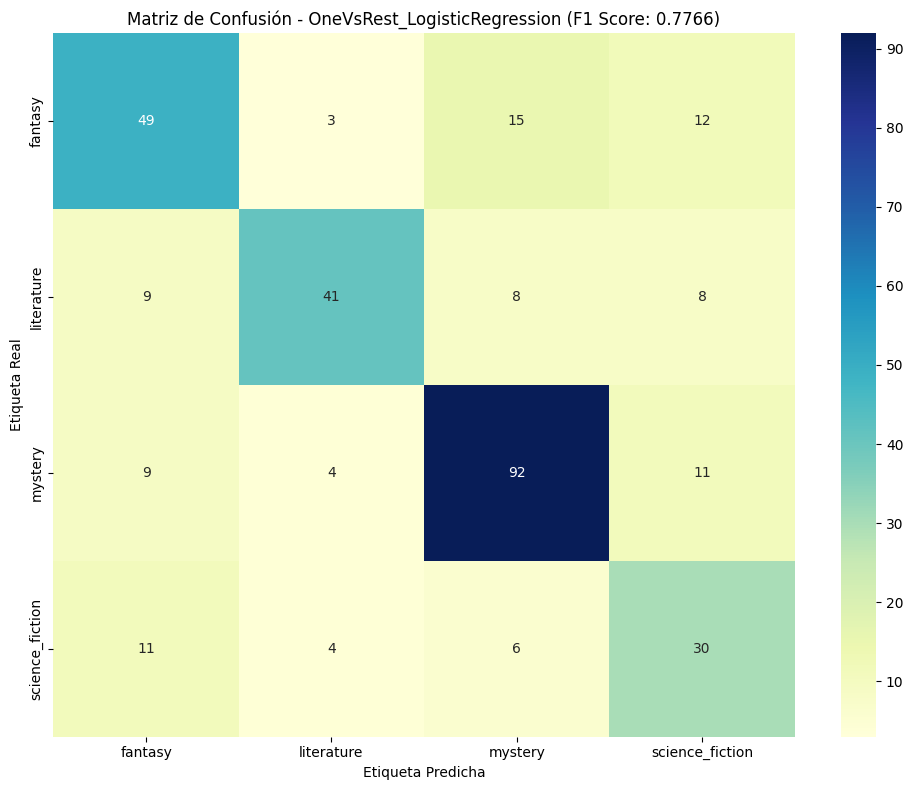

In [ ]:
modelo = "OneVsRest_LogisticRegression"
f1 = results_embeddings_sentence_transformers[modelo]["f1_score_weighted"]
y_pred = results_embeddings_sentence_transformers[modelo]["y_pred"]

matriz = matriz_etiquetas(y_test, y_pred, etiquetas=mlb.classes_)
visualizar_matriz_congruencia(matriz, modelo=modelo, f1_score=f1)

Podemos ver también la matriz de confusión para cada etiqueta, ya que la matriz anterior no permite reflejar la naturaleza multietiqueta del problema.

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multilabel_confusion(y_true, y_pred, etiquetas):
    matrices = multilabel_confusion_matrix(y_true, y_pred)
    n_labels = len(etiquetas)

    for i in range(n_labels):
        plt.figure(figsize=(4, 4))
        sns.heatmap(matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
        plt.title(f'Matriz de Confusión: {etiquetas[i]}')
        plt.xlabel('Predicho')
        plt.ylabel('Real')
        plt.tight_layout()
        plt.show()


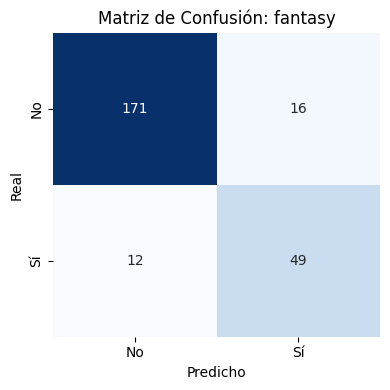

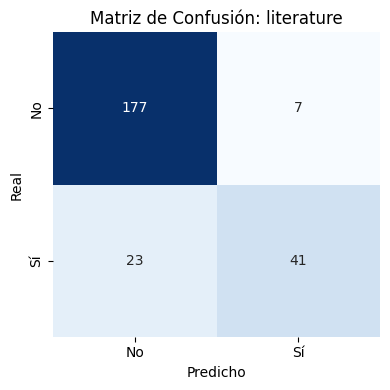

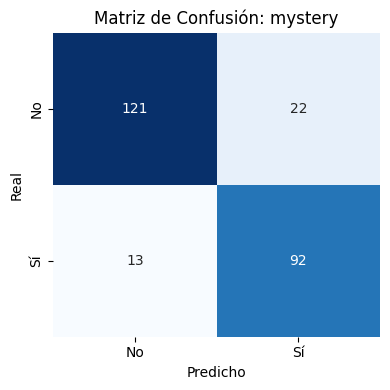

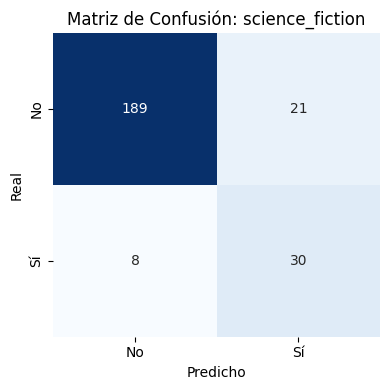

In [ ]:
modelo = results_embeddings_sentence_transformers["OneVsRest_LogisticRegression"]
y_pred = modelo["y_pred"]
y_true = y_test
etiquetas = mlb.classes_

plot_multilabel_confusion(y_true, y_pred, etiquetas)

Para observar mejor cuántos libros pertenecen a múltiples clases realizamos dos diagramas de Venn, para las etiquetas predichas y para las reales.

In [ ]:
!pip install venn

  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19701 sha256=2759028ae13883ab028f98b9143d0676f4d218dfb59c20a21a093dd4765a5eb0
  Stored in directory: /root/.cache/pip/wheels/b8/2a/b1/a1ff9ba87eb919daed348de8c17b00024dfef34b35e7002e6c
Successfully built venn


In [ ]:
from venn import venn
import pandas as pd
import matplotlib.pyplot as plt

def venn_4_true_sets(y_pred, etiquetas, titulo):
    """
    Crea un diagrama de Venn para las 4 etiquetas más frecuentes.
    """
    # Obtener las 4 etiquetas más frecuentes
    label_counts = y_pred.sum(axis=0)
    top4_idx = label_counts.argsort()[-4:]
    top4_labels = [etiquetas[i] for i in top4_idx]

    # Crear conjuntos: índice de muestras que contienen cada etiqueta
    sets = {}
    for i, label in zip(top4_idx, top4_labels):
        sets[label] = set(np.where(y_pred[:, i] == 1)[0])

    # Dibujar Venn
    venn(sets)
    plt.title(f"Diagrama de Venn: 4 géneros {titulo}")
    plt.show()



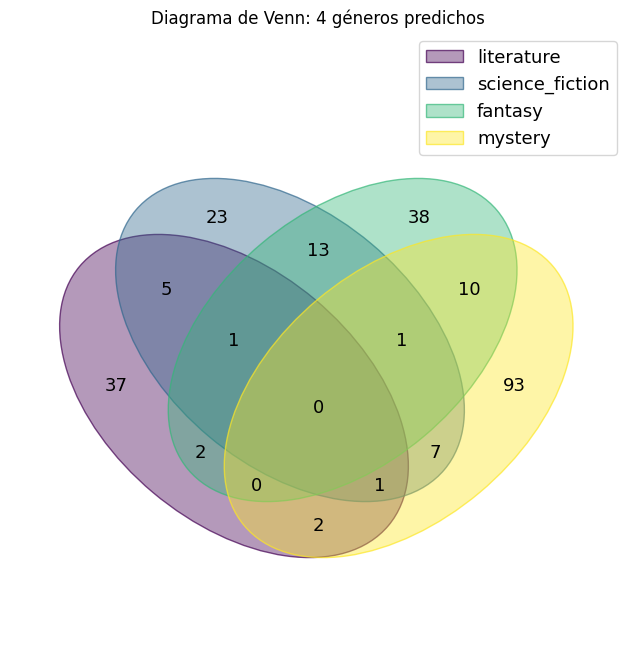

In [ ]:
modelo = results_embeddings_sentence_transformers["OneVsRest_LogisticRegression"]
y_pred = modelo["y_pred"]

venn_4_true_sets(y_pred, etiquetas=mlb.classes_, titulo = 'predichos')


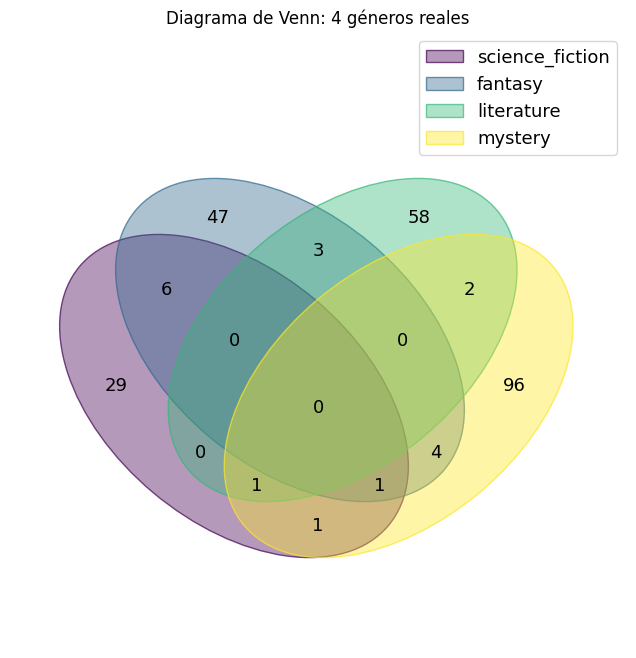

In [ ]:
y_true = y_test
venn_4_true_sets(y_true, etiquetas=mlb.classes_, titulo = 'reales')

Un método más visual para comporbar una clasificación multietiqueta con más de tres categorías son los UpsetPlots, que realizamos a continuación.

In [ ]:
!pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24862 sha256=677b20f4439b1488ffe4a3b33d1ddfed3321f8dd12fd559b11d67ae841de77af
  Stored in directory: /root/.cache/pip/wheels/7b/ce/88/1d0bce5b2680165c29c3e68416325e79674d5a9f422d037996
Successfully built upsetplot


<Figure size 1200x600 with 0 Axes>

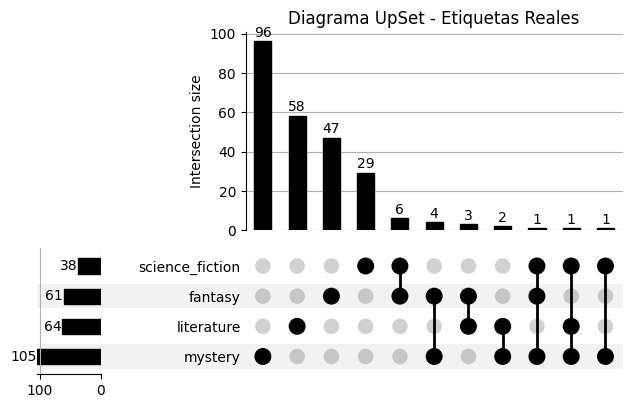

In [ ]:
from upsetplot import UpSet, from_indicators
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Convertir arrays multilabel a DataFrames booleanos
df_reales = pd.DataFrame(y_test.astype(bool), columns=mlb.classes_)
df_predichos = pd.DataFrame(y_pred.astype(bool), columns=mlb.classes_)

# Preparar datos para upsetplot
data_reales = from_indicators(df_reales.columns.tolist(), df_reales)
data_predichos = from_indicators(df_predichos.columns.tolist(), df_predichos)

# Gráfico UpSet para etiquetas reales
plt.figure(figsize=(12,6))
upset_reales = UpSet(data_reales, subset_size='count', show_counts='%d', sort_by='cardinality')
upset_reales.plot()
plt.title('Diagrama UpSet - Etiquetas Reales')
plt.show()


<Figure size 1200x600 with 0 Axes>

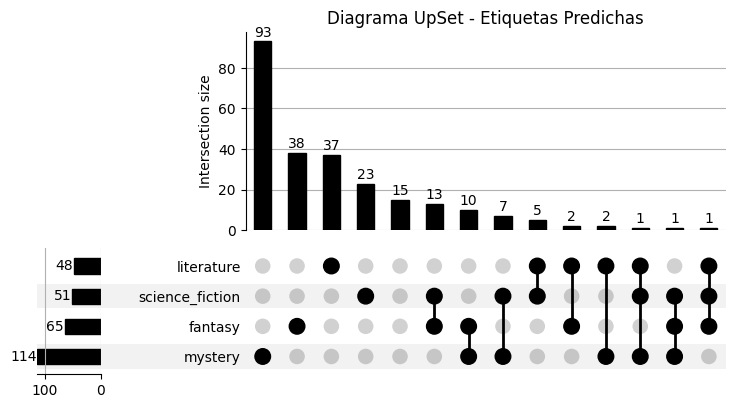

In [ ]:
# Gráfico UpSet para etiquetas predichas
plt.figure(figsize=(12,6))
upset_predichos = UpSet(data_predichos, subset_size='count', show_counts='%d', sort_by='cardinality')
upset_predichos.plot()
plt.title('Diagrama UpSet - Etiquetas Predichas')
plt.show()

Finalmente, vamos en que libros se está equivocando el modelo.

In [ ]:
import numpy as np


mal_clasificados_idx = np.where(~np.all(y_pred == y_test, axis=1))[0]

print(f"Hay {len(mal_clasificados_idx)} libros mal clasificados.")

df_mal_clasificados = df_libros.iloc[mal_clasificados_idx]
pred_labels_list = []

for i in mal_clasificados_idx:
    etiquetas_pred = np.array(mlb.classes_)[y_pred[i] == 1]
    pred_labels_list.append(", ".join(etiquetas_pred))

# Añadir columna 'pred' con las etiquetas predichas
df_mal_clasificados['pred'] = pred_labels_list
df_mal_clasificados = df_mal_clasificados.drop(columns=['preprocesado_lema', 'preprocesado','description','subjects_old'])

# Renombrar la columna 'subjects' a 'reales'
df_mal_clasificados = df_mal_clasificados.rename(columns={'subjects': 'reales'})

# Reordenar las columnas para que 'reales' esté justo antes de 'pred'
cols = list(df_mal_clasificados.columns)
cols.remove('reales')
cols.remove('pred')

# Insertar 'reales' y 'pred'
new_order = cols + ['reales', 'pred']

df_mal_clasificados = df_mal_clasificados[new_order]


Hay 86 libros mal clasificados.


<ipython-input-89-1bfd3456ed8e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mal_clasificados['pred'] = pred_labels_list


In [ ]:
df_mal_clasificados.head(20)

title  \
3                                Gulliver's Travels   
5                         Through the Looking-Glass   
6                              Five Children and It   
7                         A Midsummer Night's Dream   
9                          The Marvelous Land of Oz   
10                                       Ozma of Oz   
12                     Dorothy and the Wizard in Oz   
14  The Complete Life and Adventures of Santa Claus   
18                              The Scarecrow of Oz   
19                                  The Magic of Oz   
27                       The Phoenix and the Carpet   
28                             Nineteen Eighty-Four   
31                                       Phantastes   
33         Harry Potter and the Philosopher's Stone   
34                              Puck of Pook's Hill   
39         Harry Potter and the Prisoner of Azkaban   
40                                 The Secret Agent   
46                Charlie and the Chocolate Factory   
48                      The Princess and the Goblin   
54                                        Wet Magic   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              texto_limpio  \
3                                                                                                                                                                                    A parody of traveler’s tales and a satire of human nature, “Gulliver’s Travels” is Jonathan Swift’s most famous work which was first published in 1726. An immensely popular tale ever since its original publication, “Gulliver’s Travels” is the story of its titular character, Lemuel Gulliver, a man who loves to travel. A series of four journeys are detailed in which Gulliver finds himself in a number of amusing and precarious situations. In the first voyage, Gulliver is imprisoned by a race of tiny people, the Lilliputians, when following a shipwreck he is washed upon the shores of their island country. In his second voyage Gulliver finds himself abandoned in Brobdingnag, a land of giants, where he is exhibited for their amusement. In his third voyage, Gulliver once again finds himself marooned; fortunately he is rescued by the flying island of Laputa, a kingdom devoted to the arts of music and mathematics. He subsequently travels to the surrounding lands of Balnibarbi, Luggnagg, Glubbdubdrib, and Japan. Finally in his last voyage, when he is set adrift by a mutinous crew, he find

# 4. Modelo pre-entrenado de análisis de género

Emplearemos modelos transformers preentrenados de HuggingFace.

En un análisis preliminar se probaron los modelos encoder `distilroberta-base` y `distilbert-base-cased`. Al obtener peores resultados con RoBERTa, se descartó seguir entrenando dicho modelo. Cabe destacar que RoBERTa es una versión mejorada de BERT, con más parámetros y entrenado sobre un corpus mayor, por lo que un rendimiento inferior no era lo esperable. Esto podría deberse a que, al contar con mayor capacidad, no se logró una elección adecuada de hiperparámetros para su entrenamiento o que presenta demasiados parámetros para el corpus con el que trabajamos.

El modelo `distilbert-base-cased` empleado es una versión distilada de BERT, entrenada sobre BookCorpus (más de 11.000 libros) y Wikipedia en inglés. A nivel de datos de entrenamiento, parece razonablemente alineado con nuestro problema de clasificación. Aunque originalmente se diseñó como modelo para predicción de palabras enmascaradas, puede adaptarse a tareas de clasificación mediante fine-tuning. Es importante señalar que la variante -cased distingue entre mayúsculas y minúsculas, por lo que se ha utilizado texto limpio como input, pero sin preprocesar ni lematizar.



In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, EarlyStoppingCallback, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import precision_score, recall_score
import torch
import seaborn as sns
from transformers import TrainerCallback
import matplotlib.pyplot as plt


In [ ]:
labels = y_raw
num_labels = num_classes[0]

Para entrenar `distilbert-base-cased` con este clasificador personalizado, se utilizó el texto limpio (sin preprocesar ni lematizar) para abordar el problema de clasificación multietiqueta.

In [ ]:
# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(
    df_libros['texto_limpio'],
    labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# para almacenar los datos como un dataset
class BookDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encoding = tokenizer(
            text,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }


In [ ]:
# Crear datasets
train_dataset = BookDataset(X_train, y_train)
test_dataset = BookDataset(X_test, y_test)


Para que los resultados fuesen comparables con los modelos propios, también se de nuevo la curva precisión-recall para ajustar el un umbral óptimo de decisión para cada etiqueta.

In [ ]:
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids

    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    optimal_thresholds = []
    y_pred = np.zeros_like(probs)

    for i in range(labels.shape[1]):
         try:
             # Calcular umbral óptimo solo si hay ejemplos positivos
             if np.sum(labels[:, i]) > 0:
                 precision, recall, thresholds = precision_recall_curve(labels[:, i], probs[:, i])
                 f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
                 best_thresh = thresholds[np.argmax(f1_scores)]
                 optimal_thresholds.append(best_thresh)
                 y_pred[:, i] = (probs[:, i] >= best_thresh).astype(int)
             else:
                 optimal_thresholds.append(0.5)  # Umbral por defecto
                 y_pred[:, i] = (probs[:, i] >= 0.5).astype(int)
         except Exception as e:
             print(f"Error en clase {i}: {str(e)}")
             optimal_thresholds.append(0.5)
             y_pred[:, i] = (probs[:, i] >= 0.5).astype(int)

   # Calcular métricas comparables
    metrics = {
         'accuracy': accuracy_score(labels, y_pred),
         'f1': f1_score(labels, y_pred, average='weighted', zero_division=0),
         'precision': precision_score(labels, y_pred, average='weighted', zero_division=0),
         'recall': recall_score(labels, y_pred, average='weighted', zero_division=0),
         }

    return metrics

In [ ]:
# model_name = "distilroberta-base"
model_name = "distilbert-base-cased"

También se modificó el clasificador final que incorpora el modelo al llamarlo con `model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, problem_type="multi_label_classification")`, ya que este tenía una sola capa y se decidió añadir una capa adicional para introducir mayor no linealidad. Cabe anotar que al cargar el modelo de dicha forma, la función de coste que se aplica es `BCEWithLogitsLoss`, que combina una sigmoide con Binary Cross Entropy.

Para re-entrenar el transformer se emplearon 3 tipos diferentes de fine-tuning, entrenando en cada uno de ellos diferentes partes de la estructura del transformer.

## 4.1. Fine-Tuning basado en características

El primer tipo de fine-tuning consiste en congelar todos los parámetros del transformer menos los del clasificador.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, problem_type="multi_label_classification")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.BatchNorm1d(768),
    torch.nn.GELU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(768, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.GELU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 4)
)

In [ ]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Congelamos todo excepto el clasificador
for name, param in model.named_parameters():
    if "distilbert" in name:
        param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros no entrenables: {model.num_parameters() - trainable_params:,}")
print(f"Total de parámetros: {model.num_parameters():,}")

Parámetros entrenables: 691,332
Parámetros no entrenables: 65,190,912
Total de parámetros: 65,882,244


In [ ]:
# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-4,
    lr_scheduler_type='linear',
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    fp16=True,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

In [ ]:
# Entrenar el modelo
trainer.train()

# Evaluar
results = trainer.evaluate()
print(results)

{'eval_loss': 0.3380407989025116, 'eval_accuracy': 0.7016129032258065, 'eval_f1': 0.7982771951561936, 'eval_precision': 0.7851723498358179, 'eval_recall': 0.8171641791044776, 'eval_runtime': 1.0946, 'eval_samples_per_second': 226.574, 'eval_steps_per_second': 3.654, 'epoch': 20.0}


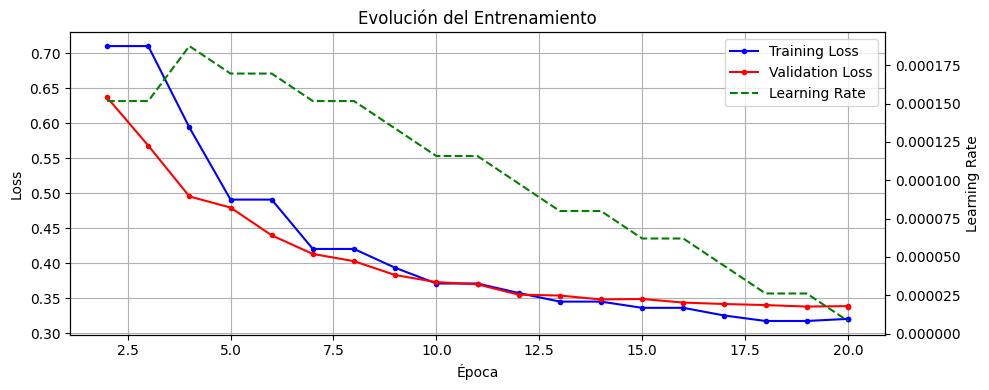

In [ ]:
# Extraer historial de entrenamiento
history = trainer.state.log_history

# Inicializar listas
epochs, train_losses, val_losses, lrs = [], [], [], []
last_train_loss, last_lr = None, None

# Recorrer historial
for entry in history:
    if 'loss' in entry:
        last_train_loss = entry['loss']
    if 'learning_rate' in entry:
        last_lr = entry['learning_rate']
    if 'eval_loss' in entry:
        if last_train_loss is not None and last_lr is not None:
            epochs.append(int(entry['epoch']))
            train_losses.append(last_train_loss)
            val_losses.append(entry['eval_loss'])
            lrs.append(last_lr)

# Verificar que hay datos
if not epochs:
    print("No hay datos suficientes para graficar.")
else:
    # Crear figura y ejes
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Gráfico de pérdidas (Loss)
    ax1.plot(epochs, train_losses, 'b.-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r.-', label='Validation Loss')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Gráfico de learning rate en eje secundario
    ax2 = ax1.twinx()
    ax2.plot(epochs, lrs, 'g--', label='Learning Rate')
    ax2.set_ylabel('Learning Rate')

    # Combinar leyendas de ambos ejes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title('Evolución del Entrenamiento')
    plt.tight_layout()
    plt.show()


A pesar de tener early stopping, el modelo realiza todas las épocas. Parece que el modelo converge bien, y que hay un ligero sobreajuste a pesar de emplear regularización L2. El F1 obtenido en la última época es 0.797428.

## 4.2. Fine-Tuning parcial (I)

Ahora congelamos los embeddings y las 4 primeras capas del transformer, entrenando las dos ultimas y el clasificador.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, problem_type="multi_label_classification")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.BatchNorm1d(768),
    torch.nn.GELU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(768, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.GELU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, num_labels)
)

In [ ]:
len(model.distilbert.transformer.layer)

6

In [ ]:
# Congelar embeddings
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

# Congelar todas las capas del Transformer excepto las últimas
for i, layer in enumerate(model.distilbert.transformer.layer):
    if i < len(model.distilbert.transformer.layer) - 2:  # congelar todas menos las ultimas
        for param in layer.parameters():
            param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros no entrenables: {model.num_parameters() - trainable_params:,}")
print(f"Total de parámetros: {model.num_parameters():,}")

Parámetros entrenables: 14,867,076
Parámetros no entrenables: 51,015,168
Total de parámetros: 65,882,244


In [ ]:
# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=4e-5,
    lr_scheduler_type='cosine',
    weight_decay=0.3,
    warmup_ratio=0.05,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    gradient_accumulation_steps=2,
    fp16=True,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

In [ ]:
# Entrenar el modelo
trainer.train()

# Evaluar
results = trainer.evaluate()
print(results)

{'eval_loss': 0.41116511821746826, 'eval_accuracy': 0.75, 'eval_f1': 0.825420830152619, 'eval_precision': 0.8120416922422519, 'eval_recall': 0.8395522388059702, 'eval_runtime': 1.0285, 'eval_samples_per_second': 241.125, 'eval_steps_per_second': 7.778, 'epoch': 15.0}


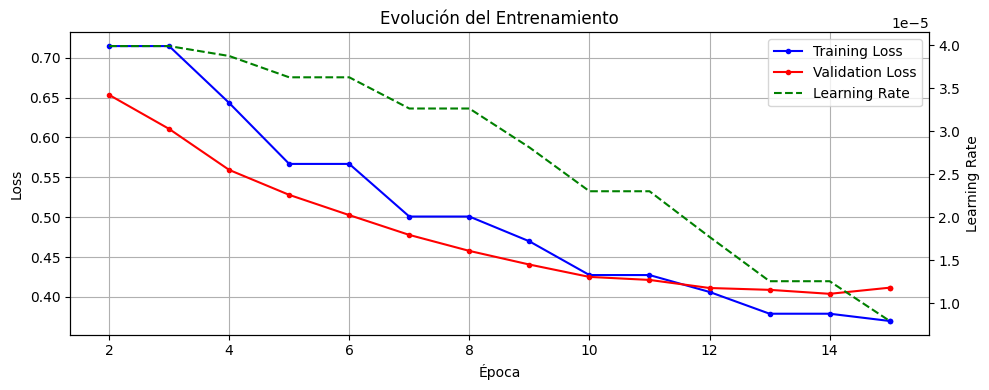

In [ ]:
history = trainer.state.log_history

# Inicializar listas
epochs, train_losses, val_losses, lrs = [], [], [], []
last_train_loss, last_lr = None, None

# Recorrer historial
for entry in history:
    if 'loss' in entry:
        last_train_loss = entry['loss']
    if 'learning_rate' in entry:
        last_lr = entry['learning_rate']
    if 'eval_loss' in entry:
        if last_train_loss is not None and last_lr is not None:
            epochs.append(int(entry['epoch']))
            train_losses.append(last_train_loss)
            val_losses.append(entry['eval_loss'])
            lrs.append(last_lr)

# Verificar que hay datos
if not epochs:
    print("No hay datos suficientes para graficar.")
else:
    # Crear figura y ejes
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Gráfico de pérdidas (Loss)
    ax1.plot(epochs, train_losses, 'b.-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r.-', label='Validation Loss')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Gráfico de learning rate en eje secundario
    ax2 = ax1.twinx()
    ax2.plot(epochs, lrs, 'g--', label='Learning Rate')
    ax2.set_ylabel('Learning Rate')

    # Combinar leyendas de ambos ejes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title('Evolución del Entrenamiento')
    plt.tight_layout()
    plt.show()


En este caso, el número de parámetros a entrenar aumenta considerablemente, por lo que a pesar de emplear una mayor regularización, vemos que el modelo tiende a sobreajustar. El modelo se detiene automáticamente en la época 15, con un F1 de 0.824441, que mejora respecto del anterior.

## 4.3. Fine-Tuning total (II)

El último tipo de Fine-Tuning consiste en reentrenar el transformer completo, incluidos los embeddings.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, problem_type="multi_label_classification")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.classifier = torch.nn.Sequential(
    torch.nn.BatchNorm1d(768),
    torch.nn.GELU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(768, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.GELU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, num_labels)
)

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Parámetros no entrenables: {model.num_parameters() - trainable_params:,}")
print(f"Total de parámetros: {model.num_parameters():,}")

Parámetros entrenables: 65,882,244
Parámetros no entrenables: 0
Total de parámetros: 65,882,244


In [ ]:
# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    lr_scheduler_type='cosine',
    weight_decay=0.3,
    warmup_ratio=0.1,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    gradient_accumulation_steps=2,
    fp16=True,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

In [ ]:
# Entrenar el modelo
trainer.train()

# Evaluar
results = trainer.evaluate()
print(results)

{'eval_loss': 0.46765372157096863, 'eval_accuracy': 0.717741935483871, 'eval_f1': 0.8184635554777259, 'eval_precision': 0.7980101776223806, 'eval_recall': 0.8432835820895522, 'eval_runtime': 1.126, 'eval_samples_per_second': 220.245, 'eval_steps_per_second': 7.105, 'epoch': 24.0}


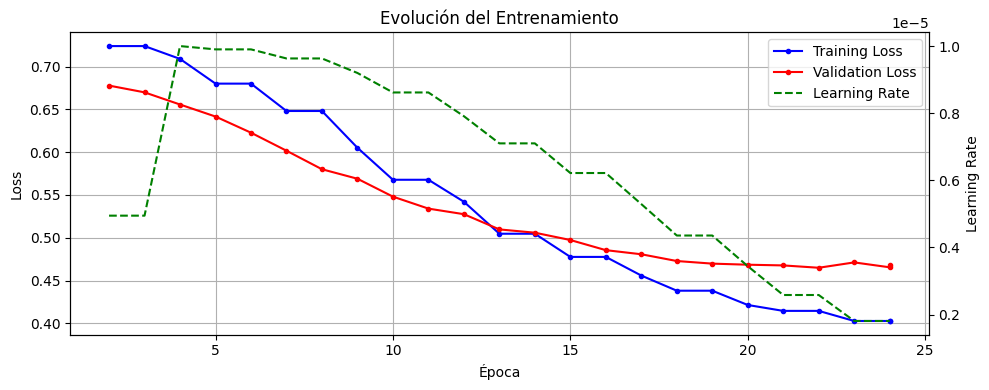

In [ ]:
import matplotlib.pyplot as plt

# Extraer historial de entrenamiento
history = trainer.state.log_history

# Inicializar listas
epochs, train_losses, val_losses, lrs = [], [], [], []
last_train_loss, last_lr = None, None

# Recorrer historial
for entry in history:
    if 'loss' in entry:
        last_train_loss = entry['loss']
    if 'learning_rate' in entry:
        last_lr = entry['learning_rate']
    if 'eval_loss' in entry:
        if last_train_loss is not None and last_lr is not None:
            epochs.append(int(entry['epoch']))
            train_losses.append(last_train_loss)
            val_losses.append(entry['eval_loss'])
            lrs.append(last_lr)

# Verificar que hay datos
if not epochs:
    print("No hay datos suficientes para graficar.")
else:
    # Crear figura y ejes
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Gráfico de pérdidas (Loss)
    ax1.plot(epochs, train_losses, 'b.-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r.-', label='Validation Loss')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Gráfico de learning rate en eje secundario
    ax2 = ax1.twinx()
    ax2.plot(epochs, lrs, 'g--', label='Learning Rate')
    ax2.set_ylabel('Learning Rate')

    # Combinar leyendas de ambos ejes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title('Evolución del Entrenamiento')
    plt.tight_layout()
    plt.show()


En este último caso, al entrenar la arquitectura completa, el número de parámetros entrenables es muy elevado. Parece que, al ser un modelo tan complejo y con tantos parámetros, los datos del corpus no son suficientes, lo que genera un mayor sobreajuste. el entrenamiento se detiene en la época 24, pero cuando lo hace el overfitting ya es muy evidente. Además, lo esperable al entrenar el modelo completo sería obtener mejores resultados, pero el F1 obtenido es de 0.816187, que no supone una mejora respecto al anterior.

Respecto a los modelos preentrenados, la principal conclusión es que, al tratarse de arquitecturas muy complejas con un número elevado de parámetros, tienden a sobreajustar si el corpus no es lo suficientemente amplio. Para evitar esto, es conveniente ampliar el conjunto de datos. Si esto no es posible, otras opciones que podrían ser interesantes son emplear otros tipos de regularización diferentes a L2 o ajustar la arquitectura interna del transformer, por ejemplo, incrementando el Dropout.

En cuanto a los resultados del F1-score, el segundo enfoque de fine-tuning ha sido el que ha ofrecido un mejor rendimiento. Además, representa un buen equilibrio respecto a los otros dos métodos, en términos tanto en tiempo de entrenamiento como en complejidad del ajuste.